# Chicago Car Crash Analysis

## Importing Packages

In [96]:
# Importing packages needed for this notebook
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.dummy import DummyClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

In [7]:
# Reading the data in

df_crashes = pd.read_csv("data/Traffic_Crashes_-_Crashes_20231109.csv")
df_vehicles = pd.read_csv("data/Traffic_Crashes_-_Vehicles_20231109.csv")
df_people = pd.read_csv("data/Traffic_Crashes_-_People_20231109.csv")

In [8]:
# Dropping columns

columns_to_drop_crashes = ['RD_NO', 'CRASH_DATE_EST_I', 'LANE_CNT', 'REPORT_TYPE', 'INTERSECTION_RELATED_I', 'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DATE_POLICE_NOTIFIED',
                           'SEC_CONTRIBUTORY_CAUSE', 'STREET_NO', 'STREET_DIRECTION', 'STREET_NAME', 'BEAT_OF_OCCURRENCE', 'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'DOORING_I',
                           'WORK_ZONE_I', 'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I', 'INJURIES_FATAL', 'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING',
                           'INJURIES_REPORTED_NOT_EVIDENT','INJURIES_NO_INDICATION', 'INJURIES_UNKNOWN', 'LATITUDE', 'LONGITUDE', 'LOCATION'
                           ]

columns_to_drop_vehicles = ['RD_NO', 'CRASH_DATE', 'CRASH_UNIT_ID', 'UNIT_NO', 'UNIT_TYPE', 'NUM_PASSENGERS', 'VEHICLE_ID', 'CMRC_VEH_I', 'MAKE', 'MODEL', 'VEHICLE_YEAR',
                            'VEHICLE_DEFECT','VEHICLE_USE', 'TRAVEL_DIRECTION', 'TOWED_I', 'FIRE_I', 'OCCUPANT_CNT', 'EXCEED_SPEED_LIMIT_I', 'TOWED_BY', 'TOWED_TO',
                            'AREA_00_I', 'AREA_01_I', 'AREA_02_I', 'AREA_03_I', 'AREA_04_I', 'AREA_05_I', 'AREA_06_I', 'AREA_07_I', 'AREA_08_I', 'AREA_09_I',
                            'AREA_10_I', 'AREA_11_I', 'AREA_12_I', 'AREA_99_I',  'CMV_ID', 'USDOT_NO', 'CCMC_NO', 'ILCC_NO', 'COMMERCIAL_SRC',
                            'GVWR', 'CARRIER_NAME', 'CARRIER_STATE', 'CARRIER_CITY', 'HAZMAT_PLACARDS_I', 'HAZMAT_NAME','UN_NO', 'HAZMAT_PRESENT_I',
                            'HAZMAT_REPORT_I', 'HAZMAT_REPORT_NO', 'MCS_REPORT_I', 'MCS_REPORT_NO', 'HAZMAT_VIO_CAUSE_CRASH_I', 'MCS_VIO_CAUSE_CRASH_I', 'IDOT_PERMIT_NO',
                            'WIDE_LOAD_I', 'TRAILER1_WIDTH', 'TRAILER2_WIDTH', 'TRAILER1_LENGTH', 'TRAILER2_LENGTH', 'TOTAL_VEHICLE_LENGTH', 'AXLE_CNT', 'VEHICLE_CONFIG', 'CARGO_BODY_TYPE',
                            'LOAD_TYPE', 'HAZMAT_OUT_OF_SERVICE_I', 'MCS_OUT_OF_SERVICE_I', 'HAZMAT_CLASS'
                            ]

columns_to_drop_people = ['RD_NO', 'CRASH_DATE', 'VEHICLE_ID', 'PERSON_ID', 'SEAT_NO', 'CITY', 'STATE', 'ZIPCODE', 'DRIVERS_LICENSE_STATE', 'DRIVERS_LICENSE_CLASS', 'EJECTION',
                          'HOSPITAL', 'EMS_AGENCY', 'EMS_RUN_NO', 'BAC_RESULT VALUE', 'PEDPEDAL_ACTION', 'PEDPEDAL_VISIBILITY', 'PEDPEDAL_LOCATION', 'CELL_PHONE_USE', 'INJURY_CLASSIFICATION'
                          ]

df_crashes = df_crashes.drop(columns_to_drop_crashes, axis=1)
df_vehicles = df_vehicles.drop(columns_to_drop_vehicles, axis=1)
df_people = df_people.drop(columns_to_drop_people, axis=1)

## Creating a Master DataFrame

In [9]:
master_df = pd.merge(df_crashes, pd.merge(df_vehicles, df_people, on="CRASH_RECORD_ID"), on="CRASH_RECORD_ID")

## Info and column names of each table

In [10]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3594423 entries, 0 to 3594422
Data columns (total 34 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   CRASH_RECORD_ID          object 
 1   CRASH_DATE               object 
 2   POSTED_SPEED_LIMIT       int64  
 3   TRAFFIC_CONTROL_DEVICE   object 
 4   DEVICE_CONDITION         object 
 5   WEATHER_CONDITION        object 
 6   LIGHTING_CONDITION       object 
 7   FIRST_CRASH_TYPE         object 
 8   TRAFFICWAY_TYPE          object 
 9   ALIGNMENT                object 
 10  ROADWAY_SURFACE_COND     object 
 11  ROAD_DEFECT              object 
 12  CRASH_TYPE               object 
 13  DAMAGE                   object 
 14  PRIM_CONTRIBUTORY_CAUSE  object 
 15  NUM_UNITS                int64  
 16  MOST_SEVERE_INJURY       object 
 17  INJURIES_TOTAL           float64
 18  CRASH_HOUR               int64  
 19  CRASH_DAY_OF_WEEK        int64  
 20  CRASH_MONTH              int64  
 21  LIC_PLAT

## Takeaway

- 3,594,423 observations
- 36 combined columns
- 987 MB combined memory file

## Data Cleaning

In [11]:
# Filtering from 2020 and on

master_df['CRASH_DATE'] = pd.to_datetime(master_df['CRASH_DATE'])
master_df['YEAR'] = master_df['CRASH_DATE'].dt.year
master_df = master_df.loc[master_df['INJURIES_TOTAL'] > 0]
master_df = master_df[
    (master_df["YEAR"] >= 2020) &
    ((master_df["VEHICLE_TYPE"] == "PASSENGER") |
     (master_df["VEHICLE_TYPE"] == "SPORT UTILITY VEHICLE (SUV)") |
     (master_df["VEHICLE_TYPE"] == "VAN/MINI-VAN"))
]
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 305598 entries, 0 to 3594374
Data columns (total 35 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   CRASH_RECORD_ID          305598 non-null  object        
 1   CRASH_DATE               305598 non-null  datetime64[ns]
 2   POSTED_SPEED_LIMIT       305598 non-null  int64         
 3   TRAFFIC_CONTROL_DEVICE   305598 non-null  object        
 4   DEVICE_CONDITION         305598 non-null  object        
 5   WEATHER_CONDITION        305598 non-null  object        
 6   LIGHTING_CONDITION       305598 non-null  object        
 7   FIRST_CRASH_TYPE         305598 non-null  object        
 8   TRAFFICWAY_TYPE          305598 non-null  object        
 9   ALIGNMENT                305598 non-null  object        
 10  ROADWAY_SURFACE_COND     305598 non-null  object        
 11  ROAD_DEFECT              305598 non-null  object        
 12  CRASH_TYPE          

## Takeaway

- We filtered the data from year 2020 and after, 

In [12]:
master_df.isna().sum()

CRASH_RECORD_ID                0
CRASH_DATE                     0
POSTED_SPEED_LIMIT             0
TRAFFIC_CONTROL_DEVICE         0
DEVICE_CONDITION               0
WEATHER_CONDITION              0
LIGHTING_CONDITION             0
FIRST_CRASH_TYPE               0
TRAFFICWAY_TYPE                0
ALIGNMENT                      0
ROADWAY_SURFACE_COND           0
ROAD_DEFECT                    0
CRASH_TYPE                     0
DAMAGE                         0
PRIM_CONTRIBUTORY_CAUSE        0
NUM_UNITS                      0
MOST_SEVERE_INJURY             0
INJURIES_TOTAL                 0
CRASH_HOUR                     0
CRASH_DAY_OF_WEEK              0
CRASH_MONTH                    0
LIC_PLATE_STATE            12230
VEHICLE_TYPE                   0
MANEUVER                       0
FIRST_CONTACT_POINT           86
PERSON_TYPE                    0
SEX                         7393
AGE                        53949
SAFETY_EQUIPMENT            1633
AIRBAG_DEPLOYED            11910
DRIVER_ACT

# Andy's Space

In [13]:
defect_dict = {"NO DEFECTS" : "NO DEFECTS", "UNKNOWN": "NO DEFECTS", "WORN SURFACE": "DEFECTS", "OTHER":"DEFECTS","RUT, HOLES": "DEFECTS", "SHOULDER DEFECT":"DEFECTS", "DEBRIS ON ROADWAY": "DEFECTS"}

master_df['ROAD_DEFECT'] = master_df['ROAD_DEFECT'].map(defect_dict)
master_df['ROAD_DEFECT'].value_counts()

ROAD_DEFECT
NO DEFECTS    301095
DEFECTS         4503
Name: count, dtype: int64

In [14]:
master_df["CRASH_TYPE"].value_counts()

CRASH_TYPE
INJURY AND / OR TOW DUE TO CRASH    305506
NO INJURY / DRIVE AWAY                  92
Name: count, dtype: int64

In [15]:
master_df["DAMAGE"].value_counts()
master_df['DAMAGE'] = master_df['DAMAGE'].apply(lambda x: 'OVER $1500' if 'OVER $1,500' in x else "UNDER $1500")
master_df['DAMAGE'].value_counts()

DAMAGE
OVER $1500     259341
UNDER $1500     46257
Name: count, dtype: int64

In [16]:
#talk about this with team
master_df["PRIM_CONTRIBUTORY_CAUSE"].value_counts()

PRIM_CONTRIBUTORY_CAUSE
UNABLE TO DETERMINE                                                                 83621
FAILING TO YIELD RIGHT-OF-WAY                                                       53085
FOLLOWING TOO CLOSELY                                                               26314
FAILING TO REDUCE SPEED TO AVOID CRASH                                              26078
DISREGARDING TRAFFIC SIGNALS                                                        24689
IMPROPER TURNING/NO SIGNAL                                                          11340
IMPROPER OVERTAKING/PASSING                                                          9315
NOT APPLICABLE                                                                       9116
DISREGARDING STOP SIGN                                                               8654
OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER     7296
DRIVING SKILLS/KNOWLEDGE/EXPERIENCE                                         

In [17]:
prim_cause_dict = { 'FOLLOWING TOO CLOSELY': "HUMAN FACTORS", 'FAILING TO REDUCE SPEED TO AVOID CRASH': "HUMAN FACTORS", 
                   'IMPROPER TURNING/NO SIGNAL': 'HUMAN FACTORS', 'IMPROPER OVERTAKING/PASSING' : 'HUMAN FACTORS',
                   'OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER': 'HUMAN FACTORS',
                   'PHYSICAL CONDITION OF DRIVER': "HUMAN FACTORS", 
                   'UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)': "HUMAN FACTORS",
                   'DISTRACTION - FROM INSIDE VEHICLE':"HUMAN FACTORS", 'DISTRACTION - FROM OUTSIDE VEHICLE': 'HUMAN FACTORS',
                   'TEXTING':"HUMAN FACTORS", 'IMPROPER BACKING':"HUMAN FACTORS", 'CELL PHONE USE OTHER THAN TEXTING': "HUMAN FACTORS",
                   'HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)': "HUMAN FACTORS", 
                   'DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)':"HUMAN FACTORS",
                   'VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)': "ENVIRONMENTAL FACTORS", 'ANIMAL': "ENVIRONMENTAL FACTORS",
                   'WEATHER': "ENVIRONMENTAL FACTORS", 'EVASIVE ACTION DUE TO ANIMAL,OBJECT, NONMOTORIST': "ENVIRONMENTAL FACTORS",
                   'FAILING TO YIELD RIGHT-OF-WAY':"SIGNAGE/TRAFFIC CONTROL DEVICES", 'DISREGARDING TRAFFIC SIGNALS': "SIGNAGE/TRAFFIC CONTROL DEVICES",
                   'DISREGARDING STOP SIGN':"SIGNAGE/TRAFFIC CONTROL DEVICES", 'DRIVING ON WRONG SIDE/WRONG WAY':"SIGNAGE/TRAFFIC CONTROL DEVICES",
                   'IMPROPER LANE USAGE': "SIGNAGE/TRAFFIC CONTROL DEVICES", 'DISREGARDING OTHER TRAFFIC SIGNS':"SIGNAGE/TRAFFIC CONTROL DEVICES",
                   'TURNING RIGHT ON RED': "SIGNAGE/TRAFFIC CONTROL DEVICES", 'DISREGARDING ROAD MARKINGS':"SIGNAGE/TRAFFIC CONTROL DEVICES",
                   'DISREGARDING YIELD SIGN': "SIGNAGE/TRAFFIC CONTROL DEVICES", 'RELATED TO BUS STOP': "SIGNAGE/TRAFFIC CONTROL DEVICES",
                   'PASSING STOPPED SCHOOL BUS': "SIGNAGE/TRAFFIC CONTROL DEVICES", 
                   'ROAD CONSTRUCTION/MAINTENANCE': "INFRASTRUCTURE ISSUES", 'ROAD ENGINEERING/SURFACE/MARKING DEFECTS': "INFRASTRUCTURE ISSUES",
                   'OBSTRUCTED CROSSWALKS': "INFRASTRUCTURE ISSUES", 
                   'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE': "MISC FACTORS", 'BICYCLE ADVANCING LEGALLY ON RED LIGHT':"MISC FACTORS",
                   'MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT':"MISC FACTORS", 'EQUIPMENT - VEHICLE CONDITION': "MISC FACTORS",
                   'NOT APPLICABLE': "MISC FACTORS"
              }

master_df['PRIM_CONTRIBUTORY_CAUSE'] = master_df['PRIM_CONTRIBUTORY_CAUSE'].map(prim_cause_dict)
master_df['PRIM_CONTRIBUTORY_CAUSE'].value_counts()

PRIM_CONTRIBUTORY_CAUSE
SIGNAGE/TRAFFIC CONTROL DEVICES    100090
HUMAN FACTORS                       95907
MISC FACTORS                        18567
ENVIRONMENTAL FACTORS                6333
INFRASTRUCTURE ISSUES                 492
Name: count, dtype: int64

<details>
  <summary>**Click Me to Expand Breakdown of PRIM_CONTRIBUTORY_CAUSE**</summary>
    
  **human factors:**
    - 'FOLLOWING TOO CLOSELY', 
    - 'FAILING TO REDUCE SPEED TO AVOID CRASH',
    - 'IMPROPER TURNING/NO SIGNAL',
    - 'IMPROPER OVERTAKING/PASSING', 
    - 'OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER',
    - 'PHYSICAL CONDITION OF DRIVER',
    - 'UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)',
    - 'DISTRACTION - FROM INSIDE VEHICLE',
    - 'DISTRACTION - FROM OUTSIDE VEHICLE',
    - 'TEXTING',
    - 'IMPROPER BACKING',
    - 'CELL PHONE USE OTHER THAN TEXTING',
    - 'HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)',
    - 'DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)',

**environmental factors:** 
    - 'VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)',
    - 'ANIMAL', 
    - 'WEATHER',
    - 'EVASIVE ACTION DUE TO ANIMAL,OBJECT, NONMOTORIST',

**traffic control devices/signage:**
    - 'FAILING TO YIELD RIGHT-OF-WAY',
    - 'DISREGARDING TRAFFIC SIGNALS',
    - 'DISREGARDING STOP SIGN',
    - 'DRIVING ON WRONG SIDE/WRONG WAY',
    - 'IMPROPER LANE USAGE',
    - 'DISREGARDING OTHER TRAFFIC SIGNS',
    - 'TURNING RIGHT ON RED',
    - 'DISREGARDING ROAD MARKINGS',
    - 'DISREGARDING YIELD SIGN',
    - 'RELATED TO BUS STOP', 
    - 'PASSING STOPPED SCHOOL BUS',

**infrastructure issues:**
    - 'ROAD CONSTRUCTION/MAINTENANCE', 
    - 'ROAD ENGINEERING/SURFACE/MARKING DEFECTS',
    - 'OBSTRUCTED CROSSWALKS',

**misc factors:**
    - 'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE', 
    - 'BICYCLE ADVANCING LEGALLY ON RED LIGHT', 
    - 'MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT'
    - 'EQUIPMENT - VEHICLE CONDITION',
- 'NOT APPLICABLE'

--
'UNABLE TO DETERMINE', - to be dropped

</details>

In [18]:
master_df["NUM_UNITS"].value_counts()
#in int form already

NUM_UNITS
2     202015
3      61190
4      22690
5       7534
1       5671
6       3596
7       1409
8       1014
9        291
12       131
11        53
14         4
Name: count, dtype: int64

In [19]:
#change to no injury, minor, major, fatality
master_df["MOST_SEVERE_INJURY"].value_counts()

injury_dict = {'NONINCAPACITATING INJURY': 'MINOR INJURIES',
              'REPORTED, NOT EVIDENT': 'MINOR INJURIES', 'INCAPACITATING INJURY' : 'MAJOR INJURIES',
              'FATAL': 'FATAL'}

master_df['SEVERE_INJURY'] = master_df['MOST_SEVERE_INJURY'].map(injury_dict)
master_df.drop(labels="MOST_SEVERE_INJURY", axis=1, inplace=True)
master_df['SEVERE_INJURY'].value_counts()

SEVERE_INJURY
MINOR INJURIES    267484
MAJOR INJURIES     35384
FATAL               2730
Name: count, dtype: int64

In [20]:
master_df["INJURIES_TOTAL"].value_counts()
master_df["CRASH_HOUR"].value_counts()
master_df["CRASH_DAY_OF_WEEK"].value_counts()
master_df["CRASH_MONTH"].value_counts()
#int form already

CRASH_MONTH
7     32695
6     30152
8     29755
10    29626
9     29217
5     28983
4     23074
3     22853
1     22210
2     20199
11    19574
12    17260
Name: count, dtype: int64

In [21]:
master_df["LIC_PLATE_STATE"].value_counts()
master_df.drop(labels="LIC_PLATE_STATE", axis=1, inplace=True)
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 305598 entries, 0 to 3594374
Data columns (total 34 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   CRASH_RECORD_ID          305598 non-null  object        
 1   CRASH_DATE               305598 non-null  datetime64[ns]
 2   POSTED_SPEED_LIMIT       305598 non-null  int64         
 3   TRAFFIC_CONTROL_DEVICE   305598 non-null  object        
 4   DEVICE_CONDITION         305598 non-null  object        
 5   WEATHER_CONDITION        305598 non-null  object        
 6   LIGHTING_CONDITION       305598 non-null  object        
 7   FIRST_CRASH_TYPE         305598 non-null  object        
 8   TRAFFICWAY_TYPE          305598 non-null  object        
 9   ALIGNMENT                305598 non-null  object        
 10  ROADWAY_SURFACE_COND     305598 non-null  object        
 11  ROAD_DEFECT              305598 non-null  object        
 12  CRASH_TYPE          

In [22]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 305598 entries, 0 to 3594374
Data columns (total 34 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   CRASH_RECORD_ID          305598 non-null  object        
 1   CRASH_DATE               305598 non-null  datetime64[ns]
 2   POSTED_SPEED_LIMIT       305598 non-null  int64         
 3   TRAFFIC_CONTROL_DEVICE   305598 non-null  object        
 4   DEVICE_CONDITION         305598 non-null  object        
 5   WEATHER_CONDITION        305598 non-null  object        
 6   LIGHTING_CONDITION       305598 non-null  object        
 7   FIRST_CRASH_TYPE         305598 non-null  object        
 8   TRAFFICWAY_TYPE          305598 non-null  object        
 9   ALIGNMENT                305598 non-null  object        
 10  ROADWAY_SURFACE_COND     305598 non-null  object        
 11  ROAD_DEFECT              305598 non-null  object        
 12  CRASH_TYPE          

# Harshitha's Space

In [23]:
# DROP unnecessary columns
# master_df.drop(columns=['CRASH_RECORD_ID', 'CRASH_DATE'], inplace=True)

In [24]:
master_df["YEAR"].value_counts()

YEAR
2021    81665
2022    78600
2023    74362
2020    70971
Name: count, dtype: int64

In [25]:
master_df["POSTED_SPEED_LIMIT"].value_counts()

POSTED_SPEED_LIMIT
30    242017
35     27154
25     14365
20      6705
40      5834
45      3531
15      3446
10      1542
55       353
5        220
0        139
50       115
3         60
39        46
60        31
26        16
7          8
9          4
33         4
24         2
2          2
29         2
34         2
Name: count, dtype: int64

In [26]:
# can bin this into binary, Yes or no
master_df["TRAFFIC_CONTROL_DEVICE"].value_counts()

TRAFFIC_CONTROL_DEVICE
TRAFFIC SIGNAL              130369
NO CONTROLS                 115428
STOP SIGN/FLASHER            47894
UNKNOWN                       6868
OTHER                         1955
YIELD                          725
PEDESTRIAN CROSSING SIGN       501
FLASHING CONTROL SIGNAL        357
DELINEATORS                    311
SCHOOL ZONE                    262
RAILROAD CROSSING GATE         259
OTHER REG. SIGN                243
OTHER WARNING SIGN             169
POLICE/FLAGMAN                 108
OTHER RAILROAD CROSSING         81
RR CROSSING SIGN                41
BICYCLE CROSSING SIGN           19
NO PASSING                       8
Name: count, dtype: int64

In [27]:
master_df['TRAFFIC_CONTROL_DEVICE'] = master_df['TRAFFIC_CONTROL_DEVICE'].apply(lambda x: 'SIGNAL' if 'SIGNAL' in x else x)
master_df['TRAFFIC_CONTROL_DEVICE'].value_counts()

TRAFFIC_CONTROL_DEVICE
SIGNAL                      130726
NO CONTROLS                 115428
STOP SIGN/FLASHER            47894
UNKNOWN                       6868
OTHER                         1955
YIELD                          725
PEDESTRIAN CROSSING SIGN       501
DELINEATORS                    311
SCHOOL ZONE                    262
RAILROAD CROSSING GATE         259
OTHER REG. SIGN                243
OTHER WARNING SIGN             169
POLICE/FLAGMAN                 108
OTHER RAILROAD CROSSING         81
RR CROSSING SIGN                41
BICYCLE CROSSING SIGN           19
NO PASSING                       8
Name: count, dtype: int64

In [28]:
master_df['TRAFFIC_CONTROL_DEVICE'] = master_df['TRAFFIC_CONTROL_DEVICE'].apply(lambda x: 'SIGN' if ' SIGN' in x else x)
master_df['TRAFFIC_CONTROL_DEVICE'].value_counts()

TRAFFIC_CONTROL_DEVICE
SIGNAL                     130726
NO CONTROLS                115428
SIGN                        48867
UNKNOWN                      6868
OTHER                        1955
YIELD                         725
DELINEATORS                   311
SCHOOL ZONE                   262
RAILROAD CROSSING GATE        259
POLICE/FLAGMAN                108
OTHER RAILROAD CROSSING        81
NO PASSING                      8
Name: count, dtype: int64

In [29]:
traffic_dict = {'NO CONTROLS': 'NO CONTROLS', 'SIGNAL':'SIGNAL', 'SIGN': 'SIGN', 'UNKNOWN': 'OTHER',
               'OTHER': 'OTHER', 'LANE USE MARKING': 'SIGN', 'YIELD':'SIGN', 'RAILROAD CROSSING GATE': 'SIGNAL',
               'SCHOOL ZONE': 'SIGN', 'DELINEATORS': 'OTHER', 'POLICE/FLAGMAN': 'OTHER', 
               'OTHER RAILROAD CROSSING': 'SIGNAL', 'NO PASSING': 'SIGN', }
master_df['TRAFFIC_CONTROL_DEVICE'] = master_df['TRAFFIC_CONTROL_DEVICE'].map(traffic_dict)
master_df['TRAFFIC_CONTROL_DEVICE'].value_counts()

TRAFFIC_CONTROL_DEVICE
SIGNAL         131066
NO CONTROLS    115428
SIGN            49862
OTHER            9242
Name: count, dtype: int64

In [30]:
master_df['DEVICE_CONDITION'].value_counts()

DEVICE_CONDITION
FUNCTIONING PROPERLY        163434
NO CONTROLS                 119932
UNKNOWN                      16368
OTHER                         2595
FUNCTIONING IMPROPERLY        1927
NOT FUNCTIONING               1194
WORN REFLECTIVE MATERIAL       100
MISSING                         48
Name: count, dtype: int64

In [31]:
device_dict = {'NO CONTROLS': 'NO CONTROLS',
               'FUNCTIONING PROPERLY': 'FUNCTIONING PROPERLY',
               'UNKNOWN': 'NO CONTROLS',
               'FUNCTIONING IMPROPERLY':'FUNCTIONING IMPROPERLY/ MISSING',
               'NOT FUNCTIONING':'FUNCTIONING IMPROPERLY/ MISSING',
               'WORN REFLECTIVE MATERIAL': 'FUNCTIONING PROPERLY',
               'MISSING': 'FUNCTIONING IMPROPERLY/ MISSING',
               'OTHER': 'FUNCTIONING PROPERLY'}
master_df['DEVICE_CONDITION'] = master_df['DEVICE_CONDITION'].map(device_dict)
master_df['DEVICE_CONDITION'].value_counts()

DEVICE_CONDITION
FUNCTIONING PROPERLY               166129
NO CONTROLS                        136300
FUNCTIONING IMPROPERLY/ MISSING      3169
Name: count, dtype: int64

In [32]:
# bin into clear or not clear? unknown = clear, other=clear 
master_df["WEATHER_CONDITION"].value_counts()

WEATHER_CONDITION
CLEAR                       249988
RAIN                         30571
CLOUDY/OVERCAST               8955
SNOW                          7895
UNKNOWN                       4641
OTHER                         1242
FREEZING RAIN/DRIZZLE         1181
BLOWING SNOW                   407
FOG/SMOKE/HAZE                 393
SLEET/HAIL                     262
SEVERE CROSS WIND GATE          61
BLOWING SAND, SOIL, DIRT         2
Name: count, dtype: int64

In [33]:
weather_dict = {'CLEAR': 'CLEAR', 'RAIN': 'INCLEMENT', 'CLOUDY/OVERCAST': 'INCLEMENT', 'SNOW': 'INCLEMENT', 'UNKNOWN': 'CLEAR', 'OTHER': 'CLEAR',
                'FREEZING RAIN/DRIZZLE': 'INCLEMENT', 'BLOWING SNOW':'INCLEMENT', 'FOG/SMOKE/HAZE': 'INCLEMENT', 'SLEET/HAIL': 'INCLEMENT', 'SEVERE CROSS WIND GATE': 'INCLEMENT',
                'BLOWING SAND, SOIL, DIRT': 'INCLEMENT'
               }
master_df['WEATHER_CONDITION'] = master_df['WEATHER_CONDITION'].map(weather_dict)
master_df['WEATHER_CONDITION'].value_counts()

WEATHER_CONDITION
CLEAR        255871
INCLEMENT     49727
Name: count, dtype: int64

In [34]:
master_df["LIGHTING_CONDITION"].value_counts()

LIGHTING_CONDITION
DAYLIGHT                  187201
DARKNESS, LIGHTED ROAD     89446
DARKNESS                   11653
DUSK                        9415
DAWN                        5033
UNKNOWN                     2850
Name: count, dtype: int64

In [35]:
lighting_dict = {'DAYLIGHT':'VISIBLE','DARKNESS, LIGHTED ROAD':'DIMINISHED VISIBILITY', 'DARKNESS':'DIMINISHED VISIBILITY',
                'DUSK':'DIMINISHED VISIBILITY', 'DAWN': 'DIMINISHED VISIBILITY', 'UNKNOWN': 'VISIBLE'}
master_df['LIGHTING_CONDITION'] = master_df['LIGHTING_CONDITION'].map(lighting_dict)
master_df['LIGHTING_CONDITION'].value_counts()

LIGHTING_CONDITION
VISIBLE                  190051
DIMINISHED VISIBILITY    115547
Name: count, dtype: int64

In [36]:
# Looking at the FIRST_CRASH_TYPE column 
master_df['FIRST_CRASH_TYPE'].value_counts()

FIRST_CRASH_TYPE
REAR END                        79129
ANGLE                           74256
TURNING                         64269
SIDESWIPE SAME DIRECTION        22372
PARKED MOTOR VEHICLE            17638
PEDESTRIAN                      14657
HEAD ON                          8905
PEDALCYCLIST                     8648
FIXED OBJECT                     6189
SIDESWIPE OPPOSITE DIRECTION     4935
REAR TO FRONT                    1520
REAR TO SIDE                     1463
OTHER OBJECT                     1087
OVERTURNED                        222
OTHER NONCOLLISION                147
REAR TO REAR                      101
ANIMAL                             32
TRAIN                              28
Name: count, dtype: int64

In [37]:
first_crash_dict = {'REAR END': 'REAR END', 'SIDESWIPE SAME DIRECTION': 'SIDE SWIPE', 'TURNING': 'TURNING', 'PARKED MOTOR VEHICLE': 'OBJECT', 'ANGLE': 'ANGLE', 'PEDESTRIAN': 'PERSON OR ANIMAL',
                    'SIDESWIPE OPPOSITE DIRECTION': 'SIDE SWIPE', 'FIXED OBJECT': 'OBJECT', 'PEDALCYCLIST': 'PERSON OR ANIMAL', 'HEAD ON': 'OTHER', 'REAR TO FRONT': 'OTHER',
                    'REAR TO SIDE': 'OTHER', 'OTHER OBJECT': 'OBJECT', 'REAR TO REAR': 'OTHER', 'OTHER NONCOLLISION': 'OTHER', 'ANIMAL': 'PERSON OR ANIMAL', 'OVERTURNED': 'OTHER', 'TRAIN': 'OTHER'
                    }
master_df['FIRST_CRASH_TYPE'] = master_df['FIRST_CRASH_TYPE'].map(first_crash_dict)
master_df['FIRST_CRASH_TYPE'].value_counts()

FIRST_CRASH_TYPE
REAR END            79129
ANGLE               74256
TURNING             64269
SIDE SWIPE          27307
OBJECT              24914
PERSON OR ANIMAL    23337
OTHER               12386
Name: count, dtype: int64

In [38]:
master_df['TRAFFICWAY_TYPE'].value_counts()

TRAFFICWAY_TYPE
NOT DIVIDED                        116522
FOUR WAY                            66367
DIVIDED - W/MEDIAN (NOT RAISED)     48121
DIVIDED - W/MEDIAN BARRIER          22812
ONE-WAY                             17980
T-INTERSECTION                      10854
OTHER                                5286
PARKING LOT                          3756
CENTER TURN LANE                     2954
UNKNOWN INTERSECTION TYPE            2455
ALLEY                                1796
FIVE POINT, OR MORE                  1199
Y-INTERSECTION                       1197
TRAFFIC ROUTE                        1067
UNKNOWN                              1033
NOT REPORTED                          853
RAMP                                  662
DRIVEWAY                              432
L-INTERSECTION                        154
ROUNDABOUT                             98
Name: count, dtype: int64

In [39]:
#  
trafficway_dict = {'NOT DIVIDED': 'NOT DIVIDED', 'DIVIDED - W/MEDIAN (NOT RAISED)': 'DIVIDED', 'ONE-WAY': 'OTHER', 'FOUR WAY': 'OTHER', 'DIVIDED - W/MEDIAN BARRIER': 'DIVIDED',
                    'PARKING LOT': 'OTHER', 'OTHER': 'OTHER', 'T-INTERSECTION': 'INTERSECTION', 'ALLEY': 'OTHER', 'UNKNOWN': 'NOT DIVIDED', 'CENTER TURN LANE': 'OTHER', 
                    'UNKNOWN INTERSECTION TYPE': 'INTERSECTION', 'RAMP': 'OTHER', 'DRIVEWAY': 'OTHER', 'FIVE POINT, OR MORE': 'OTHER', 'Y-INTERSECTION': 'INTERSECTION', 
                    'TRAFFIC ROUTE': 'OTHER', 'NOT REPORTED': 'OTHER', 'ROUNDABOUT': 'INTERSECTION', 'L-INTERSECTION': 'INTERSECTION'
               }
master_df['TRAFFICWAY_TYPE'] = master_df['TRAFFICWAY_TYPE'].map(trafficway_dict)
master_df['TRAFFICWAY_TYPE'].value_counts()

TRAFFICWAY_TYPE
NOT DIVIDED     117555
OTHER           102352
DIVIDED          70933
INTERSECTION     14758
Name: count, dtype: int64

In [40]:
# Street alignment at crash location, as determined by reporting officer. maybe drop?
alignment_dict = {'STRAIGHT AND LEVEL': 'STRAIGHT', 'STRAIGHT ON GRADE': 'STRAIGHT', 'CURVE, LEVEL': 'NOT STRAIGHT', 'STRAIGHT ON HILLCREST': 'STRAIGHT',
                    'CURVE ON GRADE': 'NOT STRAIGHT', 'CURVE ON HILLCREST': 'NOT STRAIGHT'
               }
master_df['ALIGNMENT'] = master_df['ALIGNMENT'].map(alignment_dict)
master_df['ALIGNMENT'].value_counts()

ALIGNMENT
STRAIGHT        302355
NOT STRAIGHT      3243
Name: count, dtype: int64

In [41]:
roadway_surface_dict = {'DRY': 'DRY', 'WET': 'NOT DRY', 'UNKNOWN': 'DRY', 'SNOW OR SLUSH': 'NOT DRY', 'ICE': 'NOT DRY', 
                'OTHER': 'OTHER', 'SAND, MUD, DIRT': 'NOT DRY'
               }
master_df['ROADWAY_SURFACE_COND'] = master_df['ROADWAY_SURFACE_COND'].map(roadway_surface_dict)
master_df['ROADWAY_SURFACE_COND'].value_counts()

ROADWAY_SURFACE_COND
DRY        249355
NOT DRY     55410
OTHER         833
Name: count, dtype: int64

# Dre's Space

In [42]:
## Vehicle Type

master_df['VEHICLE_TYPE'].value_counts()

VEHICLE_TYPE
PASSENGER                      238025
SPORT UTILITY VEHICLE (SUV)     51648
VAN/MINI-VAN                    15925
Name: count, dtype: int64

In [43]:
# Maneuver

MANEUVER_dict = {'STRAIGHT AHEAD': 'STRAIGHT', 'TURNING LEFT': 'OTHER', 'SLOW/STOP IN TRAFFIC': 'OTHER', 'PARKED': 'OTHER', 'TURNING RIGHT': 'OTHER', 'UNKNOWN/NA': 'STRAIGHT',
                 'OTHER': 'OTHER', 'PASSING/OVERTAKING': 'OTHER', 'CHANGING LANES': 'OTHER', 'U-TURN': 'OTHER', 'BACKING': 'OTHER', 'STARTING IN TRAFFIC': 'OTHER', 
                 'AVOIDING VEHICLES/OBJECTS': 'OTHER', 'ENTERING TRAFFIC LANE FROM PARKING': 'OTHER', 'SKIDDING/CONTROL LOSS': 'OTHER', 'DRIVING WRONG WAY': 'OTHER',
                 'MERGING': 'OTHER', 'ENTER FROM DRIVE/ALLEY': 'OTHER', 'PARKED IN TRAFFIC LANE': 'OTHER', 'NEGOTIATING A CURVE': 'OTHER', 'LEAVING TRAFFIC LANE TO PARK': 'OTHER',
                 'TURNING ON RED': 'OTHER', 'DISABLED': 'OTHER', 'DRIVERLESS': 'OTHER', 'DIVERGING': 'OTHER'}

master_df['MANEUVER'] = master_df['MANEUVER'].map(MANEUVER_dict)

In [44]:

master_df['MANEUVER'].value_counts()

MANEUVER
STRAIGHT    194291
OTHER       111307
Name: count, dtype: int64

In [45]:
# FIRST CONTACT POINT

master_df['FIRST_CONTACT_POINT'] = master_df['FIRST_CONTACT_POINT'].fillna('FRONT')

FIRST_CONTACT_POINT_dict = {'FRONT': 'FRONT', 'REAR': 'REAR', 'FRONT-LEFT-CORNER': 'FRONT', 'FRONT-RIGHT-CORNER': 'FRONT', 'SIDE-LEFT': 'SIDES', 'SIDE-RIGHT': 'SIDES', 
                            'REAR-LEFT-CORNER': 'REAR',
                            'REAR-RIGHT-CORNER':'REAR', 'SIDE-LEFT-REAR': 'SIDES', 'SIDE-LEFT-FRONT':'SIDES', 'SIDE-RIGHT-REAR':'SIDES', 'SIDE-RIGHT-FRONT': 'SIDES',
                            'TOTAL (ALL AREAS)': 'OTHER', 'NONE': 'NONE', 'OTHER': 'OTHER', 'UNDER CARRIAGE': 'OTHER', 'TOP': 'OTHER', 'ROOF': 'OTHER', 'UNKNOWN': 'FRONT',
                            'REAR-LEFT': 'REAR', 'FRONT-RIGHT': 'FRONT'}

master_df['FIRST_CONTACT_POINT'] = master_df['FIRST_CONTACT_POINT'].map(FIRST_CONTACT_POINT_dict)

In [46]:
master_df['FIRST_CONTACT_POINT'].value_counts(dropna=False)

FIRST_CONTACT_POINT
FRONT    179686
REAR      63448
SIDES     57061
OTHER      4030
NONE       1373
Name: count, dtype: int64

In [47]:
# Person Type

PERSON_TYPE_dict = {'DRIVER': 'DRIVER', 'PASSENGER': 'PASSENGER', 'PEDESTRIAN': 'OTHER', 'BICYCLE': 'OTHER', 'NON-MOTOR VEHICLE': 'OTHER', 'NON-CONTACT VEHICLE': 'OTHER'}

master_df['PERSON_TYPE'] = master_df['PERSON_TYPE'].map(PERSON_TYPE_dict)

In [48]:
master_df['PERSON_TYPE'].value_counts(dropna=False)

PERSON_TYPE
DRIVER       198143
PASSENGER     95401
OTHER         12054
Name: count, dtype: int64

In [49]:
# Sex

master_df = master_df[master_df['SEX'] != 'X']

master_df['SEX'].value_counts(dropna=False)

SEX
M      157656
F      129998
NaN      7393
Name: count, dtype: int64

In [50]:
# Age

master_df['AGE'].value_counts()

# Filter for ages 16-75??

AGE
25.0     7372
23.0     7232
27.0     7173
24.0     7132
28.0     7108
         ... 
101.0       4
110.0       2
97.0        2
108.0       2
105.0       1
Name: count, Length: 107, dtype: int64

In [51]:
# Safety Equipment

master_df['SAFETY_EQUIPMENT'] = master_df['SAFETY_EQUIPMENT'].fillna('USAGE UNKNOWN')

SAFETY_EQUIPMENT_dict = {'USAGE UNKNOWN': 'UNKNOWN', 'SAFETY BELT USED': 'USED', 'NONE PRESENT': 'NONE', 'HELMET NOT USED': 'NOT USED', 'SAFETY BELT NOT USED': 'NOT USED',
                         'CHILD RESTRAINT - FORWARD FACING': 'USED', 'BICYCLE HELMET (PEDACYCLIST INVOLVED ONLY)': 'USED', 'CHILD RESTRAINT - TYPE UNKNOWN': 'USED',
                         'CHILD RESTRAINT - REAR FACING': 'USED', 'DOT COMPLIANT MOTORCYCLE HELMET': 'USED', 'BOOSTER SEAT': 'USED', 'CHILD RESTRAINT NOT USED': 'NOT USED', 
                         'CHILD RESTRAINT USED IMPROPERLY': 'USED', 'NOT DOT COMPLIANT MOTORCYCLE HELMET': 'USED', 'WHEELCHAIR': 'USED', 'SHOULD/LAP BELT USED IMPROPERLY': 'USED',
                         'HELMET USED': 'USED', 'STRETCHER': 'USED', 'CHILD RESTRAINT USED': 'USED'}

master_df['SAFETY_EQUIPMENT'] = master_df['SAFETY_EQUIPMENT'].map(SAFETY_EQUIPMENT_dict)

In [52]:
master_df['SAFETY_EQUIPMENT'].value_counts(dropna=False)

SAFETY_EQUIPMENT
UNKNOWN     139877
USED        136400
NONE         12606
NOT USED      6164
Name: count, dtype: int64

In [53]:
# Airbag Deployed

master_df['AIRBAG_DEPLOYED'] = master_df['AIRBAG_DEPLOYED'].fillna('DID NOT DEPLOY')

AIRBAG_DEPLOYED_dict = {'DID NOT DEPLOY': 'DID NOT DEPLOY', 'NOT APPLICABLE': 'NOT APPLICABLE', 'DEPLOYED, COMBINATION': 'DEPLOYED', 'DEPLOYMENT UNKNOWN': 'UNKNOWN', 
                        'DEPLOYED, FRONT': 'DEPLOYED', 'DEPLOYED, SIDE': 'DEPLOYED', 'DEPLOYED OTHER (KNEE, AIR, BELT, ETC.)': 'DEPLOYED'}

master_df['AIRBAG_DEPLOYED'] = master_df['AIRBAG_DEPLOYED'].map(AIRBAG_DEPLOYED_dict)

In [54]:
master_df['AIRBAG_DEPLOYED'].value_counts(dropna=False)

AIRBAG_DEPLOYED
DID NOT DEPLOY    115041
DEPLOYED           83943
NOT APPLICABLE     65199
UNKNOWN            30864
Name: count, dtype: int64

In [55]:
# Driver Action

master_df['DRIVER_ACTION'] = master_df['DRIVER_ACTION'].fillna('NONE')

DRIVER_ACTION_dict = {'NONE': 'NO ACTION TAKEN', 'UNKNOWN': 'NO ACTION TAKEN', 'FAILED TO YIELD': 'ACTIONS TAKEN', 'OTHER': 'ACTIONS TAKEN', 'DISREGARDED CONTROL DEVICES': 'ACTIONS TAKEN',
                      'FOLLOWED TOO CLOSELY': 'ACTIONS TAKEN', 'TOO FAST FOR CONDITIONS': 'ACTIONS TAKEN', 'IMPROPER TURN': 'ACTIONS TAKEN', 'IMPROPER LANE CHANGE': 'ACTIONS TAKEN',
                      'IMPROPER PASSING': 'ACTIONS TAKEN', 'WRONG WAY/SIDE': 'ACTIONS TAKEN', 'IMPROPER BACKING': 'ACTIONS TAKEN', 'OVERCORRECTED': 'ACTIONS TAKEN', 'EVADING POLICE VEHICLE': 'ACTIONS TAKEN',
                      'CELL PHONE USE OTHER THAN TEXTING': 'ACTIONS TAKEN', 'EMERGENCY VEHICLE ON CALL': 'ACTIONS TAKEN', 'IMPROPER PARKING': 'ACTIONS TAKEN', 'TEXTING': 'ACTIONS TAKEN',
                      'LICENSE RESTRICTIONS': 'ACTIONS TAKEN', 'STOPPED SCHOOL BUS': 'ACTIONS TAKEN'}

master_df['DRIVER_ACTION'] = master_df['DRIVER_ACTION'].map(DRIVER_ACTION_dict)

In [56]:
master_df['DRIVER_ACTION'].value_counts(dropna=False)

DRIVER_ACTION
NO ACTION TAKEN    216815
ACTIONS TAKEN       78232
Name: count, dtype: int64

In [57]:
# Driver Vision

master_df['DRIVER_VISION'] = master_df['DRIVER_VISION'].fillna('NONE')

DRIVER_VISION_dict = { 'NONE':'UNKNOWN', 'NOT OBSCURED': 'NOT OBSCURED', 'UNKNOWN': 'UNKNOWN', 'OTHER': 'OBSCURED', 'MOVING VEHICLES': 'OBSCURED', 'PARKED VEHICLES': 'OBSCURED',
                      'WINDSHIELD (WATER/ICE)': 'OBSCURED', 'BLINDED - SUNLIGHT': 'OBSCURED', 'TREES, PLANTS': 'OBSCURED', 'BUILDINGS': 'OBSCURED',
                      'BLINDED - HEADLIGHTS': 'OBSCURED', 'BLOWING MATERIALS': 'OBSCURED', 'HILLCREST': 'OBSCURED',
                      'EMBANKMENT': 'OBSCURED', 'SIGNBOARD': 'OBSCURED'}

master_df['DRIVER_VISION'] = master_df['DRIVER_VISION'].map(DRIVER_VISION_dict)

In [58]:
master_df['DRIVER_VISION'].value_counts(dropna=False)

DRIVER_VISION
UNKNOWN         182906
NOT OBSCURED    105706
OBSCURED          6435
Name: count, dtype: int64

In [59]:
# Physical Condition

master_df['PHYSICAL_CONDITION'] = master_df['PHYSICAL_CONDITION'].fillna('UNKNOWN')

PHYSICAL_CONDITION_dict = {'UNKNOWN': 'UNKNOWN', 'NORMAL': 'NORMAL', 'REMOVED BY EMS': 'NOT NORMAL', 'IMPAIRED - ALCOHOL': 'NOT NORMAL', 'OTHER': 'NOT NORMAL', 'EMOTIONAL': 'NOT NORMAL',
                           'FATIGUED/ASLEEP': 'NOT NORMAL', 'ILLNESS/FAINTED': 'NOT NORMAL', 'IMPAIRED - DRUGS': 'NOT NORMAL', 'HAD BEEN DRINKING': 'NOT NORMAL', 
                           'IMPAIRED - ALCOHOL AND DRUGS': 'NOT NORMAL', 'MEDICATED': 'NOT NORMAL'}

master_df['PHYSICAL_CONDITION'] = master_df['PHYSICAL_CONDITION'].map(PHYSICAL_CONDITION_dict)

In [60]:
master_df['PHYSICAL_CONDITION'].value_counts(dropna=False)

PHYSICAL_CONDITION
NORMAL        146803
UNKNOWN       137339
NOT NORMAL     10905
Name: count, dtype: int64

In [61]:
# BAC Result

master_df['BAC_RESULT'] = master_df['BAC_RESULT'].fillna('UNKNOWN')

BAC_RESULT_dict = {'TEST NOT OFFERED': 'TEST NOT OFFERED', 'TEST REFUSED': 'TEST REFUSED', 'TEST PERFORMED, RESULTS UNKNOWN': 'TEST PERFORMED',
                   'TEST TAKEN': 'TEST PERFORMED'}

master_df['BAC_RESULT'] = master_df['BAC_RESULT'].map(BAC_RESULT_dict)

In [62]:
master_df['BAC_RESULT'].value_counts()

BAC_RESULT
TEST NOT OFFERED    195341
TEST REFUSED          2702
TEST PERFORMED        1955
Name: count, dtype: int64

## Preprocessing for Modeling

In [63]:
#View our cleaned columns
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 295047 entries, 0 to 3594374
Data columns (total 34 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   CRASH_RECORD_ID          295047 non-null  object        
 1   CRASH_DATE               295047 non-null  datetime64[ns]
 2   POSTED_SPEED_LIMIT       295047 non-null  int64         
 3   TRAFFIC_CONTROL_DEVICE   295047 non-null  object        
 4   DEVICE_CONDITION         295047 non-null  object        
 5   WEATHER_CONDITION        295047 non-null  object        
 6   LIGHTING_CONDITION       295047 non-null  object        
 7   FIRST_CRASH_TYPE         295047 non-null  object        
 8   TRAFFICWAY_TYPE          295047 non-null  object        
 9   ALIGNMENT                295047 non-null  object        
 10  ROADWAY_SURFACE_COND     295047 non-null  object        
 11  ROAD_DEFECT              295047 non-null  object        
 12  CRASH_TYPE          

In [64]:
#We can get rid of RECORD_ID and DATE, not relevant for ML
master_df.drop(labels=["CRASH_RECORD_ID","CRASH_DATE"], axis=1, inplace=True)

In [65]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 295047 entries, 0 to 3594374
Data columns (total 32 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   POSTED_SPEED_LIMIT       295047 non-null  int64  
 1   TRAFFIC_CONTROL_DEVICE   295047 non-null  object 
 2   DEVICE_CONDITION         295047 non-null  object 
 3   WEATHER_CONDITION        295047 non-null  object 
 4   LIGHTING_CONDITION       295047 non-null  object 
 5   FIRST_CRASH_TYPE         295047 non-null  object 
 6   TRAFFICWAY_TYPE          295047 non-null  object 
 7   ALIGNMENT                295047 non-null  object 
 8   ROADWAY_SURFACE_COND     295047 non-null  object 
 9   ROAD_DEFECT              295047 non-null  object 
 10  CRASH_TYPE               295047 non-null  object 
 11  DAMAGE                   295047 non-null  object 
 12  PRIM_CONTRIBUTORY_CAUSE  214640 non-null  object 
 13  NUM_UNITS                295047 non-null  int64  
 14  INJURIES

In [99]:
master_df.dropna(subset=["PRIM_CONTRIBUTORY_CAUSE"],inplace=True)
master_df.dropna(subset=["SEX"], inplace=True)

In [100]:
#Set our target
y = master_df["PRIM_CONTRIBUTORY_CAUSE"]
X = master_df.drop("PRIM_CONTRIBUTORY_CAUSE", axis=1)

In [101]:
#Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100)

In [102]:
#Check for any missing values left
X_train.isna().sum()

POSTED_SPEED_LIMIT            0
TRAFFIC_CONTROL_DEVICE        0
DEVICE_CONDITION              0
WEATHER_CONDITION             0
LIGHTING_CONDITION            0
FIRST_CRASH_TYPE              0
TRAFFICWAY_TYPE               0
ALIGNMENT                     0
ROADWAY_SURFACE_COND          0
ROAD_DEFECT                   0
CRASH_TYPE                    0
DAMAGE                        0
NUM_UNITS                     0
INJURIES_TOTAL                0
CRASH_HOUR                    0
CRASH_DAY_OF_WEEK             0
CRASH_MONTH                   0
VEHICLE_TYPE                  0
MANEUVER                      0
FIRST_CONTACT_POINT           0
PERSON_TYPE                   0
SEX                           0
AGE                       19470
SAFETY_EQUIPMENT              0
AIRBAG_DEPLOYED               0
DRIVER_ACTION                 0
DRIVER_VISION                 0
PHYSICAL_CONDITION            0
BAC_RESULT                48482
YEAR                          0
SEVERE_INJURY                 0
dtype: i

In [69]:
#SEX - drop missing values
# X_train.dropna(subset=["SEX"], inplace=True)

In [70]:
X_train.isna().sum()

POSTED_SPEED_LIMIT            0
TRAFFIC_CONTROL_DEVICE        0
DEVICE_CONDITION              0
WEATHER_CONDITION             0
LIGHTING_CONDITION            0
FIRST_CRASH_TYPE              0
TRAFFICWAY_TYPE               0
ALIGNMENT                     0
ROADWAY_SURFACE_COND          0
ROAD_DEFECT                   0
CRASH_TYPE                    0
DAMAGE                        0
NUM_UNITS                     0
INJURIES_TOTAL                0
CRASH_HOUR                    0
CRASH_DAY_OF_WEEK             0
CRASH_MONTH                   0
VEHICLE_TYPE                  0
MANEUVER                      0
FIRST_CONTACT_POINT           0
PERSON_TYPE                   0
SEX                           0
AGE                       28414
SAFETY_EQUIPMENT              0
AIRBAG_DEPLOYED               0
DRIVER_ACTION                 0
DRIVER_VISION                 0
PHYSICAL_CONDITION            0
BAC_RESULT                65719
YEAR                          0
SEVERE_INJURY                 0
dtype: i

In [71]:
#age 
X_train["AGE"].value_counts()

AGE
25.0     5499
23.0     5418
27.0     5358
24.0     5354
28.0     5336
         ... 
102.0       5
100.0       4
101.0       3
110.0       2
105.0       1
Name: count, Length: 105, dtype: int64

In [72]:
X_train["AGE"]=X_train['AGE'].fillna(X_train['AGE'].mean())
X_train['AGE'].value_counts()

AGE
35.598172     28414
25.000000      5499
23.000000      5418
27.000000      5358
24.000000      5354
              ...  
102.000000        5
100.000000        4
101.000000        3
110.000000        2
105.000000        1
Name: count, Length: 106, dtype: int64

In [73]:
X_train['BAC_RESULT'].fillna(value="TEST NOT OFFERED",axis=0, inplace=True)
X_train['BAC_RESULT'].value_counts()

BAC_RESULT
TEST NOT OFFERED    212220
TEST REFUSED          2032
TEST PERFORMED        1491
Name: count, dtype: int64

In [74]:
X_train.info()
X_train.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 215743 entries, 1316341 to 702273
Data columns (total 31 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   POSTED_SPEED_LIMIT      215743 non-null  int64  
 1   TRAFFIC_CONTROL_DEVICE  215743 non-null  object 
 2   DEVICE_CONDITION        215743 non-null  object 
 3   WEATHER_CONDITION       215743 non-null  object 
 4   LIGHTING_CONDITION      215743 non-null  object 
 5   FIRST_CRASH_TYPE        215743 non-null  object 
 6   TRAFFICWAY_TYPE         215743 non-null  object 
 7   ALIGNMENT               215743 non-null  object 
 8   ROADWAY_SURFACE_COND    215743 non-null  object 
 9   ROAD_DEFECT             215743 non-null  object 
 10  CRASH_TYPE              215743 non-null  object 
 11  DAMAGE                  215743 non-null  object 
 12  NUM_UNITS               215743 non-null  int64  
 13  INJURIES_TOTAL          215743 non-null  float64
 14  CRASH_HOUR         

POSTED_SPEED_LIMIT        0
TRAFFIC_CONTROL_DEVICE    0
DEVICE_CONDITION          0
WEATHER_CONDITION         0
LIGHTING_CONDITION        0
FIRST_CRASH_TYPE          0
TRAFFICWAY_TYPE           0
ALIGNMENT                 0
ROADWAY_SURFACE_COND      0
ROAD_DEFECT               0
CRASH_TYPE                0
DAMAGE                    0
NUM_UNITS                 0
INJURIES_TOTAL            0
CRASH_HOUR                0
CRASH_DAY_OF_WEEK         0
CRASH_MONTH               0
VEHICLE_TYPE              0
MANEUVER                  0
FIRST_CONTACT_POINT       0
PERSON_TYPE               0
SEX                       0
AGE                       0
SAFETY_EQUIPMENT          0
AIRBAG_DEPLOYED           0
DRIVER_ACTION             0
DRIVER_VISION             0
PHYSICAL_CONDITION        0
BAC_RESULT                0
YEAR                      0
SEVERE_INJURY             0
dtype: int64

In [75]:
##list of columns to be encoded:
category_list = ['TRAFFIC_CONTROL_DEVICE','DEVICE_CONDITION',"WEATHER_CONDITION","LIGHTING_CONDITION","FIRST_CRASH_TYPE","TRAFFICWAY_TYPE",
                 "ALIGNMENT","ROADWAY_SURFACE_COND","ROAD_DEFECT","CRASH_TYPE","DAMAGE","VEHICLE_TYPE","MANEUVER","FIRST_CONTACT_POINT","PERSON_TYPE","SEX",
                "SAFETY_EQUIPMENT","AIRBAG_DEPLOYED","DRIVER_ACTION","DRIVER_VISION","PHYSICAL_CONDITION","BAC_RESULT","SEVERE_INJURY"]

In [77]:
#We will One-hot encode all of our columns
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(categories='auto')

encoded_train_arr = ohe.fit_transform(X_train[category_list]).toarray()
encoded_train_labels = ohe.get_feature_names_out()
encoded_train_labels
encoded_train_labels = np.array(encoded_train_labels).ravel()
encoded_train_arr = pd.DataFrame(encoded_train_arr, columns = encoded_train_labels, index=X_train.index)
encoded_train_arr

,TRAFFIC_CONTROL_DEVICE_NO CONTROLS,TRAFFIC_CONTROL_DEVICE_OTHER,TRAFFIC_CONTROL_DEVICE_SIGN,TRAFFIC_CONTROL_DEVICE_SIGNAL,DEVICE_CONDITION_FUNCTIONING IMPROPERLY/ MISSING,DEVICE_CONDITION_FUNCTIONING PROPERLY,DEVICE_CONDITION_NO CONTROLS,WEATHER_CONDITION_CLEAR,WEATHER_CONDITION_INCLEMENT,LIGHTING_CONDITION_DIMINISHED VISIBILITY,...,DRIVER_VISION_UNKNOWN,PHYSICAL_CONDITION_NORMAL,PHYSICAL_CONDITION_NOT NORMAL,PHYSICAL_CONDITION_UNKNOWN,BAC_RESULT_TEST NOT OFFERED,BAC_RESULT_TEST PERFORMED,BAC_RESULT_TEST REFUSED,SEVERE_INJURY_FATAL,SEVERE_INJURY_MAJOR INJURIES,SEVERE_INJURY_MINOR INJURIES
1316341,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
1292667,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2171485,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
3402319,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
3187369,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2642959,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
821396,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
3151933,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2618407,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [78]:
#Drop the original columns and append our encoded array
X_train.drop(category_list, axis=1, inplace=True)
X_train = pd.concat([X_train, encoded_train_arr], axis=1)

In [79]:
# Visually inspect X_train
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 215743 entries, 1316341 to 702273
Data columns (total 78 columns):
 #   Column                                            Non-Null Count   Dtype  
---  ------                                            --------------   -----  
 0   POSTED_SPEED_LIMIT                                215743 non-null  int64  
 1   NUM_UNITS                                         215743 non-null  int64  
 2   INJURIES_TOTAL                                    215743 non-null  float64
 3   CRASH_HOUR                                        215743 non-null  int64  
 4   CRASH_DAY_OF_WEEK                                 215743 non-null  int64  
 5   CRASH_MONTH                                       215743 non-null  int64  
 6   AGE                                               215743 non-null  float64
 7   YEAR                                              215743 non-null  int32  
 8   TRAFFIC_CONTROL_DEVICE_NO CONTROLS                215743 non-null  float64
 9   TRA

## Modeling: 

## **Testing:**

In [80]:
#Do the same changes to X_test:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73762 entries, 923368 to 1737261
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   POSTED_SPEED_LIMIT      73762 non-null  int64  
 1   TRAFFIC_CONTROL_DEVICE  73762 non-null  object 
 2   DEVICE_CONDITION        73762 non-null  object 
 3   WEATHER_CONDITION       73762 non-null  object 
 4   LIGHTING_CONDITION      73762 non-null  object 
 5   FIRST_CRASH_TYPE        73762 non-null  object 
 6   TRAFFICWAY_TYPE         73762 non-null  object 
 7   ALIGNMENT               73762 non-null  object 
 8   ROADWAY_SURFACE_COND    73762 non-null  object 
 9   ROAD_DEFECT             73762 non-null  object 
 10  CRASH_TYPE              73762 non-null  object 
 11  DAMAGE                  73762 non-null  object 
 12  NUM_UNITS               73762 non-null  int64  
 13  INJURIES_TOTAL          73762 non-null  float64
 14  CRASH_HOUR              73762 non-nu

In [81]:
#deal with missing values

X_test["AGE"]=X_test['AGE'].fillna(X_test['AGE'].mean())
X_test['BAC_RESULT'].fillna(value="TEST NOT OFFERED",axis=0, inplace=True)

#encode the categoricals
encoded_test_arr = ohe.fit_transform(X_test[category_list]).toarray()
encoded_test_labels = ohe.get_feature_names_out()
encoded_test_labels
encoded_test_labels = np.array(encoded_test_labels).ravel()
encoded_test_arr = pd.DataFrame(encoded_test_arr, columns = encoded_test_labels, index=X_test.index)
encoded_test_arr

#drop orginal column and append our encoded columns
X_test.drop(category_list, axis=1, inplace=True)
X_test = pd.concat([X_test, encoded_test_arr], axis=1)

In [ ]:
#inspect X_test
X_test.info()
X_test.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71911 entries, 923368 to 1737261
Data columns (total 78 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   POSTED_SPEED_LIMIT                   71911 non-null  int64  
 1   NUM_UNITS                            71911 non-null  int64  
 2   INJURIES_TOTAL                       71911 non-null  float64
 3   CRASH_HOUR                           71911 non-null  int64  
 4   CRASH_DAY_OF_WEEK                    71911 non-null  int64  
 5   CRASH_MONTH                          71911 non-null  int64  
 6   AGE                                  71911 non-null  float64
 7   YEAR                                 71911 non-null  int64  
 8   x0_NO CONTROLS                       71911 non-null  float64
 9   x0_OTHER                             71911 non-null  float64
 10  x0_SIGN                              71911 non-null  float64
 11  x0_SIGNAL            

POSTED_SPEED_LIMIT    0
NUM_UNITS             0
INJURIES_TOTAL        0
CRASH_HOUR            0
CRASH_DAY_OF_WEEK     0
                     ..
x21_TEST PERFORMED    0
x21_TEST REFUSED      0
x22_FATAL             0
x22_MAJOR INJURIES    0
x22_MINOR INJURIES    0
Length: 78, dtype: int64

# Modeling

**Dummy Model**

In [103]:
X = master_df.drop(["PRIM_CONTRIBUTORY_CAUSE"], axis=1)
y = master_df["PRIM_CONTRIBUTORY_CAUSE"]

In [104]:
dummy_model = DummyClassifier(strategy="most_frequent")

In [107]:
# Train the model on the training set
dummy_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = dummy_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")



Accuracy: 0.4491548110754169


In [ ]:
Dummy model with different X

In [110]:
X = master_df.drop(["PRIM_CONTRIBUTORY_CAUSE"], axis=1)
y = master_df["PRIM_CONTRIBUTORY_CAUSE"]
dummy_classifier = DummyClassifier(strategy="uniform")

# Train the model on the training set
dummy_classifier.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = dummy_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")

Accuracy: 0.20169802661771455


In [111]:
X = master_df.drop(["PRIM_CONTRIBUTORY_CAUSE"], axis=1)
y = master_df["PRIM_CONTRIBUTORY_CAUSE"]
dummy_classifier = DummyClassifier(strategy="stratified")

# Train the model on the training set
dummy_classifier.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = dummy_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")

Accuracy: 0.39687547804803425


In [113]:
X = master_df['ROADWAY_SURFACE_COND']
y = master_df["PRIM_CONTRIBUTORY_CAUSE"]

dt_classifier = DecisionTreeClassifier(random_state=42)

In [114]:
dt_classifier.fit(X_train, y_train)

ValueError: could not convert string to float: 'SIGN'

In [ ]:
y_pred = dt_classifier.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

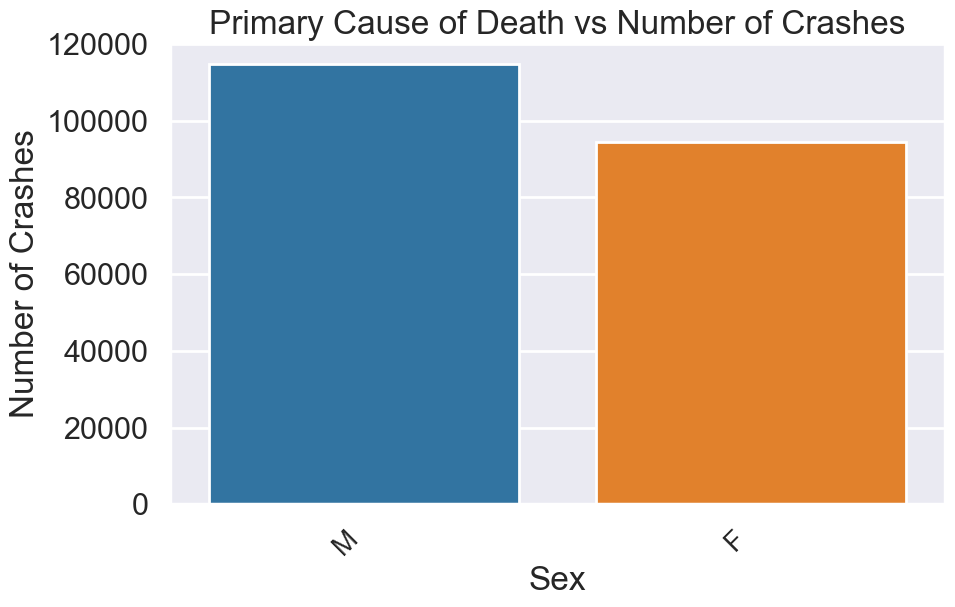

In [118]:
sns.set_context("poster")
sns.set_style("darkgrid")
plt.figure(figsize =(10,6))
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontsize='small'
)

ax = sns.countplot(x="SEX", data=master_df,order = master_df['SEX'].value_counts().head(30).index)
plt.xlabel('Sex')
plt.ylabel('Number of Crashes')
plt.title('Primary Cause of Death vs Number of Crashes')
plt.show()

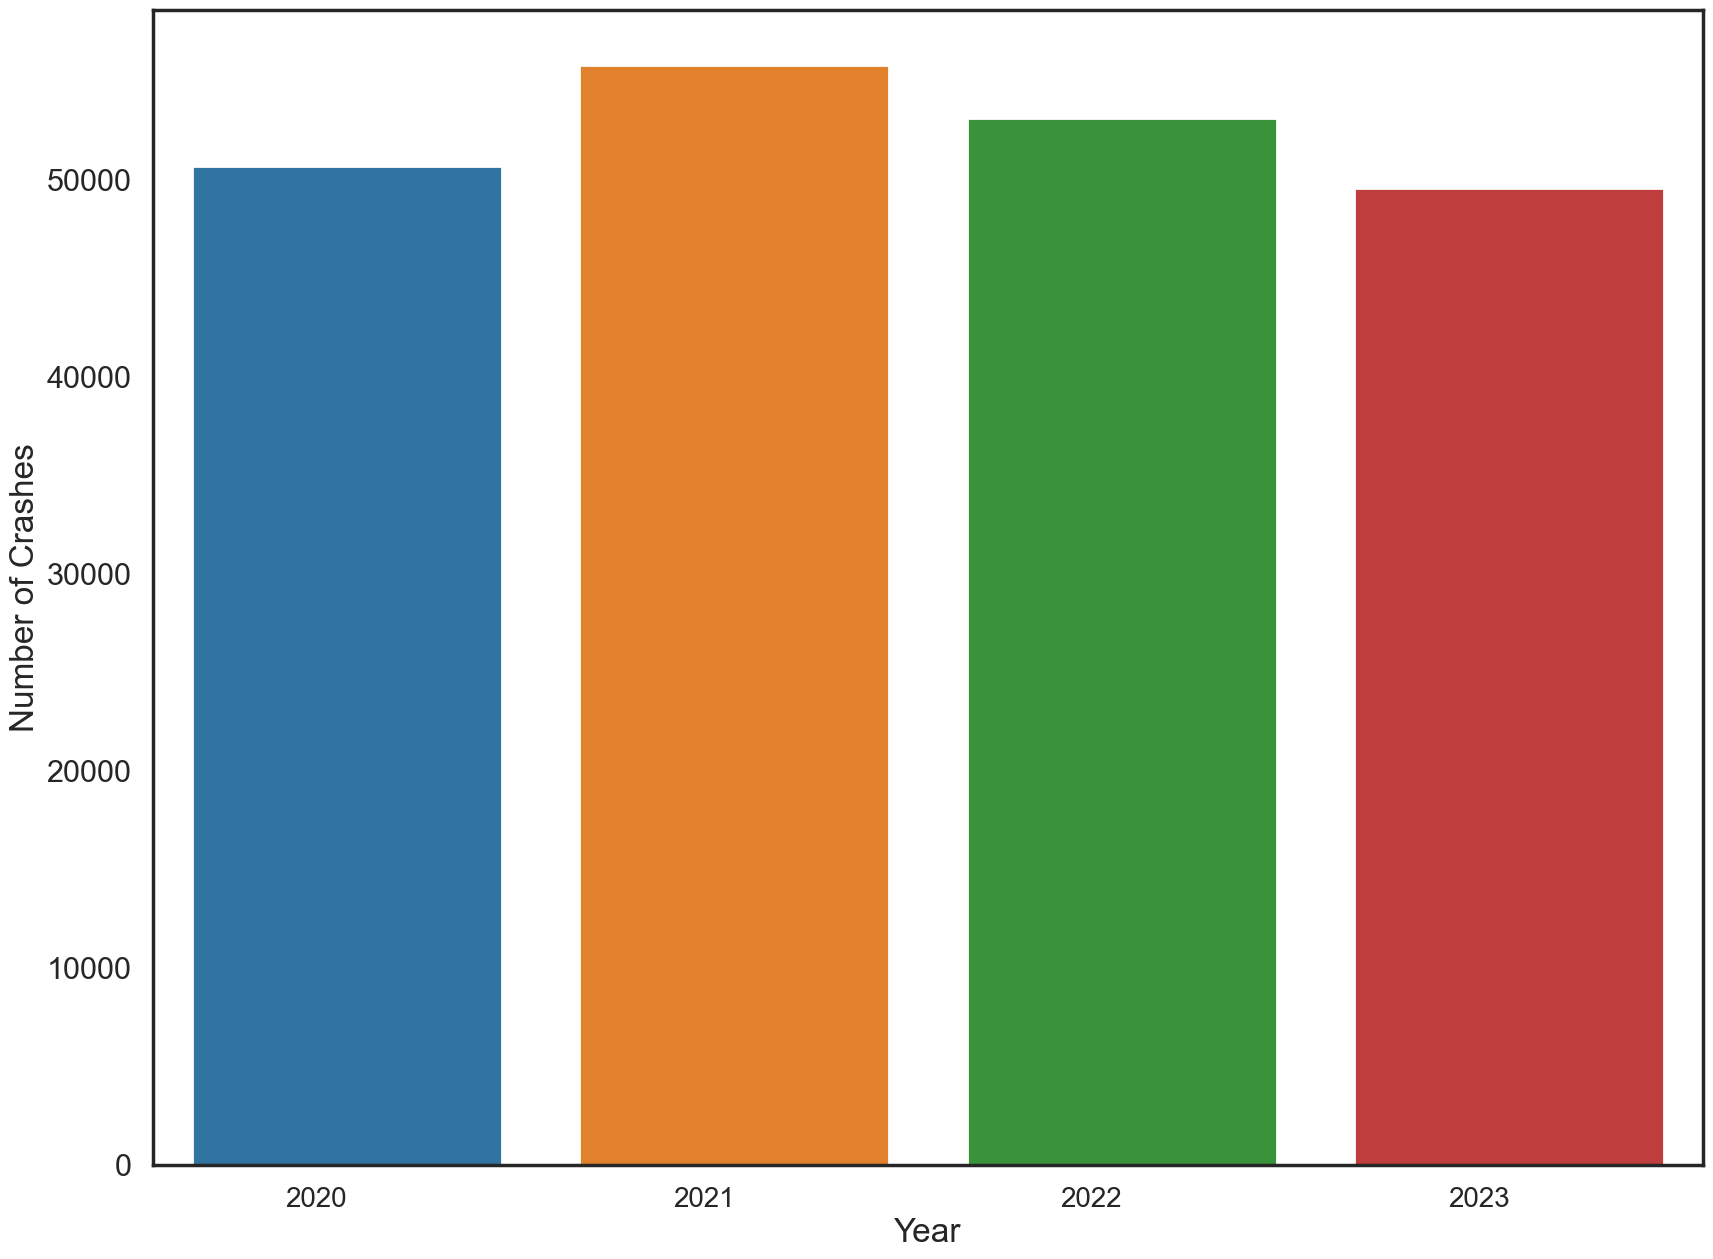

In [122]:
sns.set_context("poster")
sns.set_style("white")
plt.figure(figsize =(20,15))
plt.xticks(
    horizontalalignment='right',
    fontsize='small'
)

ax = sns.countplot(x="YEAR", data=master_df)
plt.xlabel('Year')
plt.ylabel('Number of Crashes')
plt.show() 




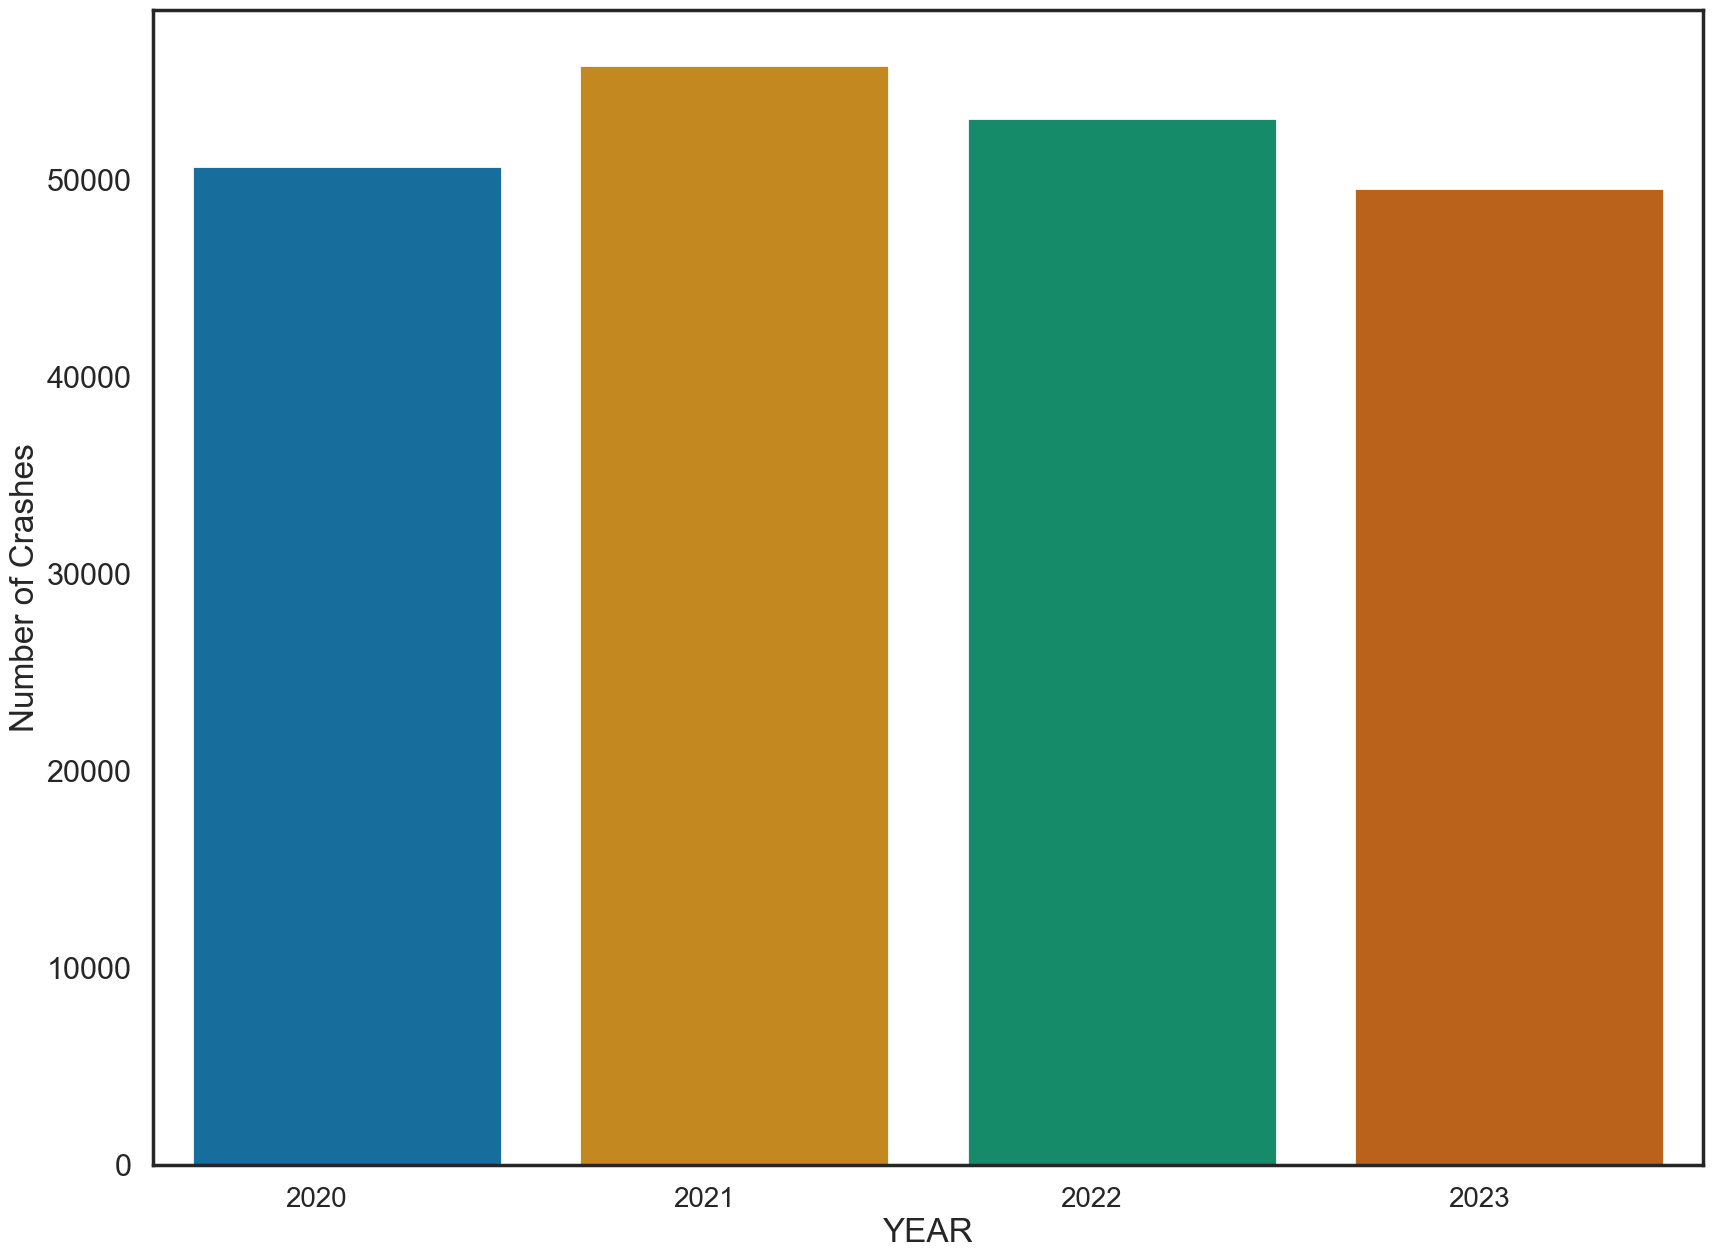

In [128]:
year_counts = master_df['YEAR'].value_counts()

# Create a custom color palette
colors = sns.color_palette("colorblind", len(year_counts))

# Create a bar chart with different colors
plt.figure(figsize=(20, 15))
ax = sns.barplot(x=year_counts.index, y=year_counts.values, palette=colors)

# Customize the x-axis labels for better readability
plt.xticks(ha='right', fontsize='small')

# Set labels and title
plt.ylabel('Number of Crashes')

# Show the plot
plt.show()

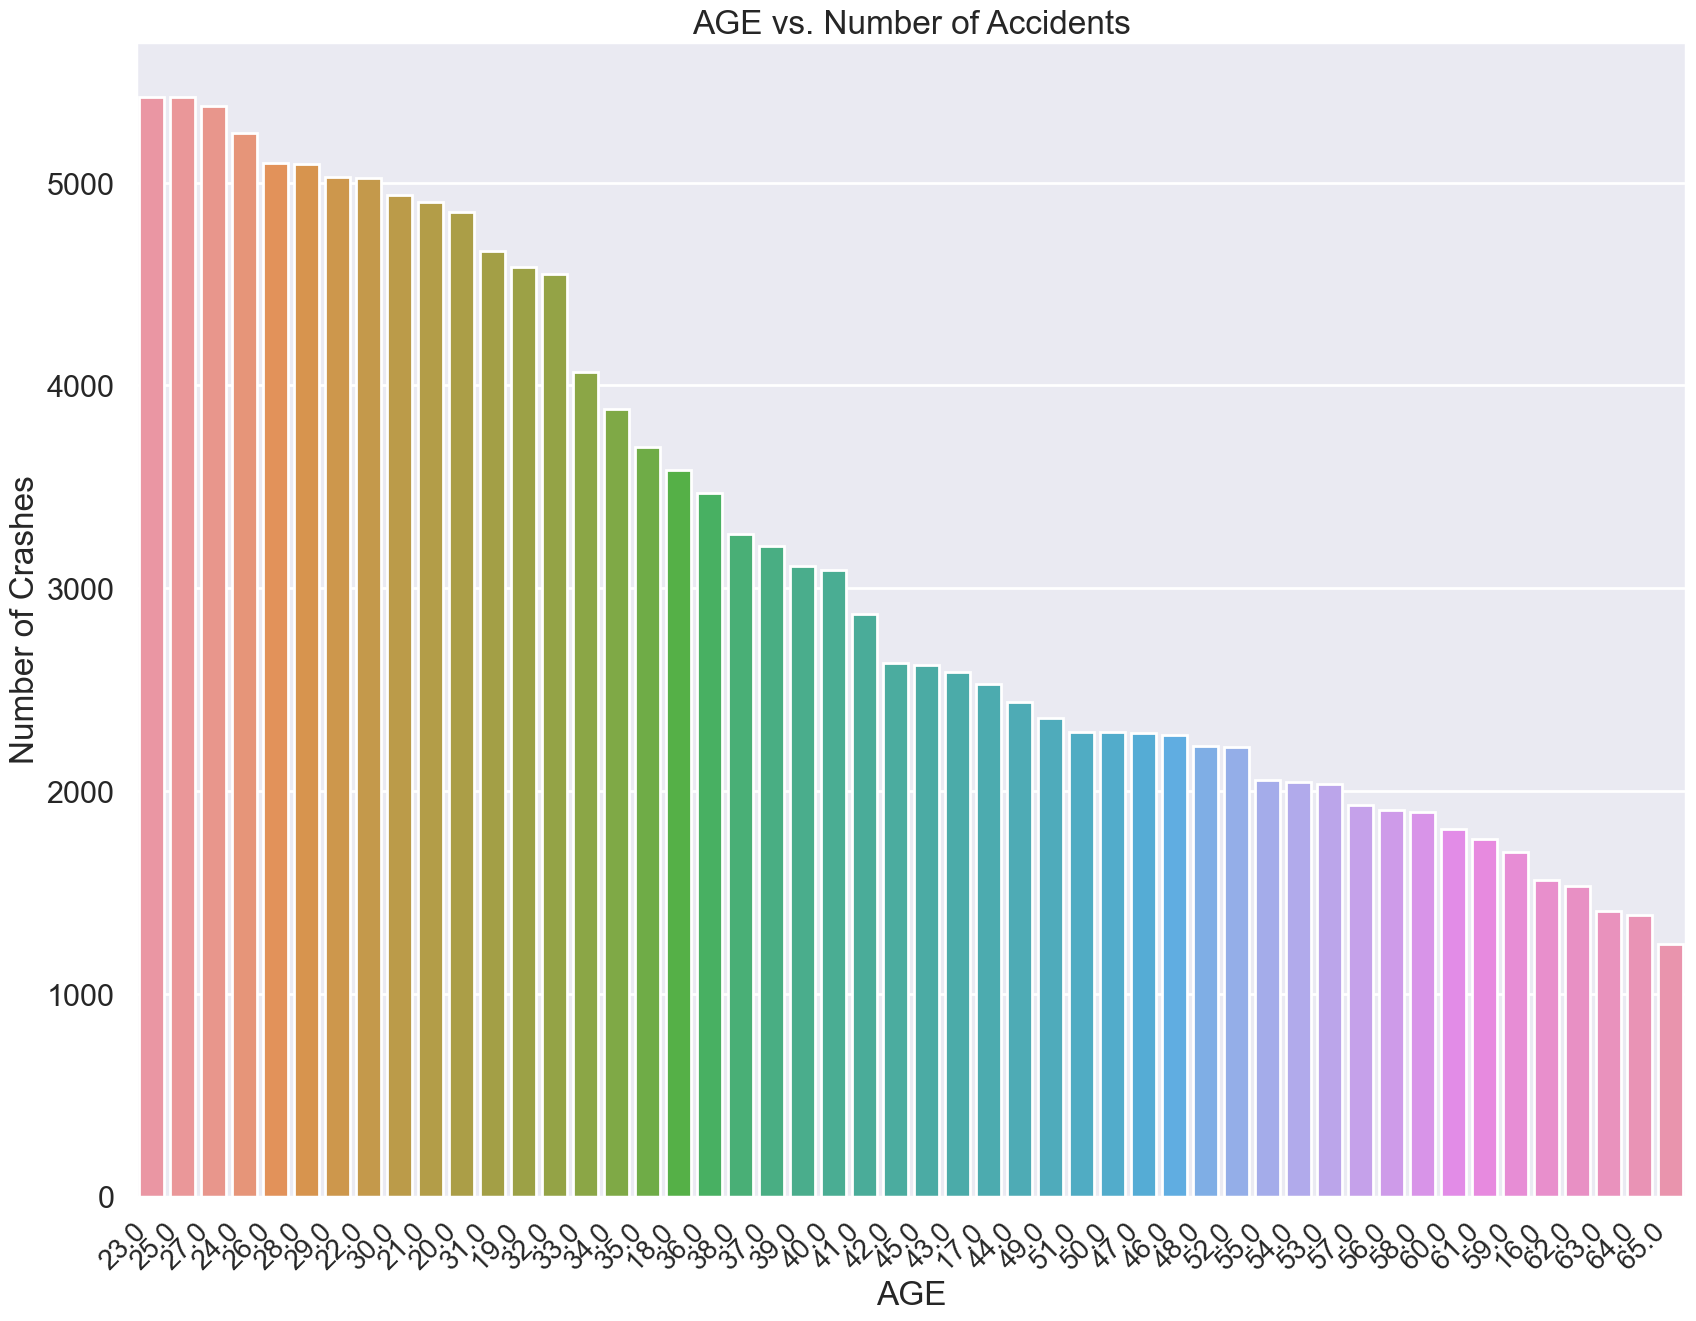

In [133]:
##AGE

filtered_master_df = master_df[(master_df['AGE'] >= 16) & (master_df['AGE'] <= 65)]

# Set Seaborn styling
sns.set_context("poster")
sns.set_style("darkgrid")

# Create a figure
plt.figure(figsize=(20, 15))

# Customize x-axis labels for better readability
plt.xticks(rotation=45, horizontalalignment='right', fontsize='small')

# Create a count plot
ax = sns.countplot(x="AGE", data=filtered_master_df, order=filtered_master_df['AGE'].value_counts().index)

# Set labels and title
plt.xlabel('AGE')
plt.ylabel('Number of Crashes')
plt.title('AGE vs. Number of Accidents')

# Show the plot
plt.show()

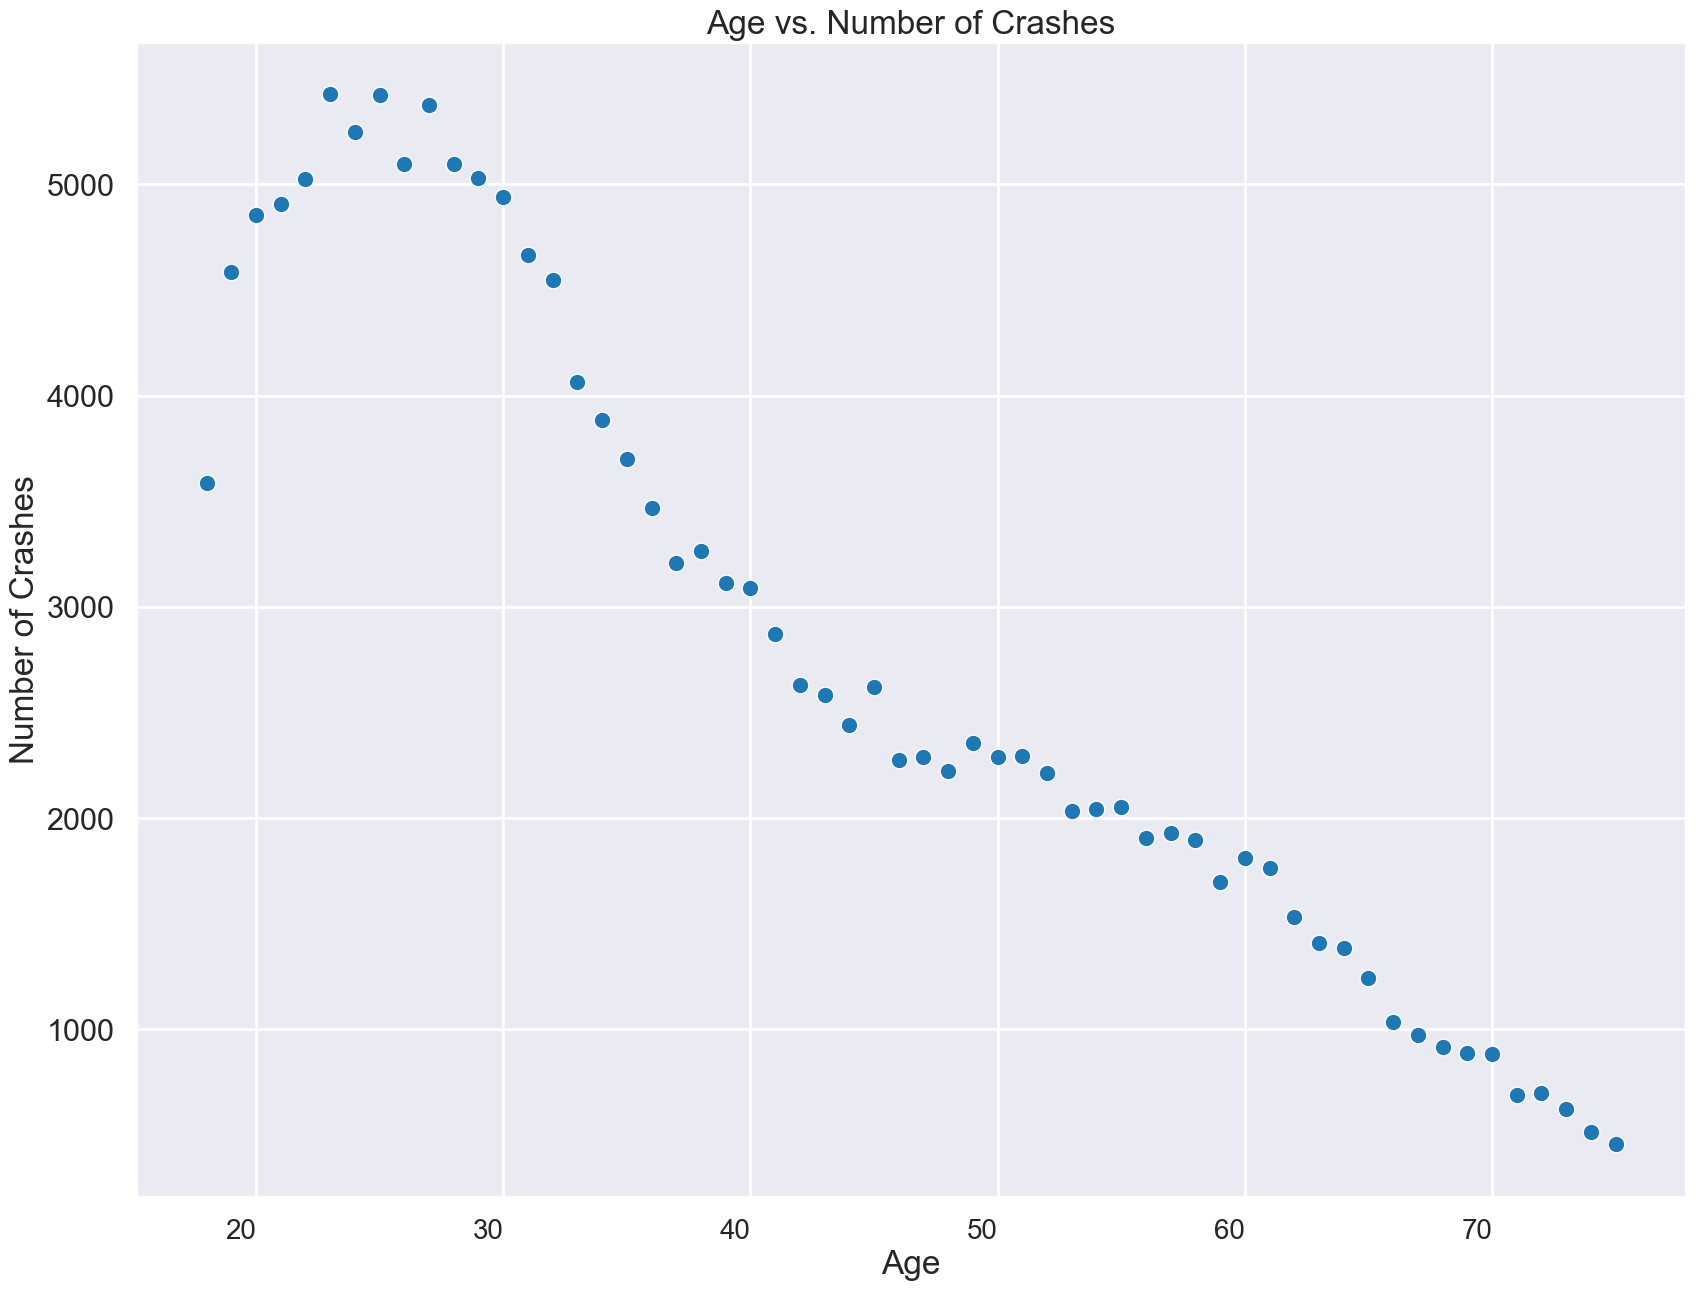

In [143]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'master_df' is your DataFrame
# Assuming 'AGE' is the column you want to use for the x-axis
sns.set_context("poster")
sns.set_style("darkgrid")

# Filter data between ages 18 and 75
filtered_master_df = master_df[(master_df['AGE'] >= 18) & (master_df['AGE'] <= 75)]

# Create a figure
plt.figure(figsize=(20, 15))

# Compute the counts of each unique age within the filtered data
age_counts = filtered_master_df['AGE'].value_counts()

# Create a scatter plot
ax = sns.scatterplot(x=age_counts.index, y=age_counts.values)

# Customize x-axis labels for better readability
plt.xticks(horizontalalignment='right', fontsize='small')

# Set labels and title
plt.xlabel('Age')
plt.ylabel('Number of Crashes')
plt.title('Age vs. Number of Crashes')

# Show the plot
plt.show()


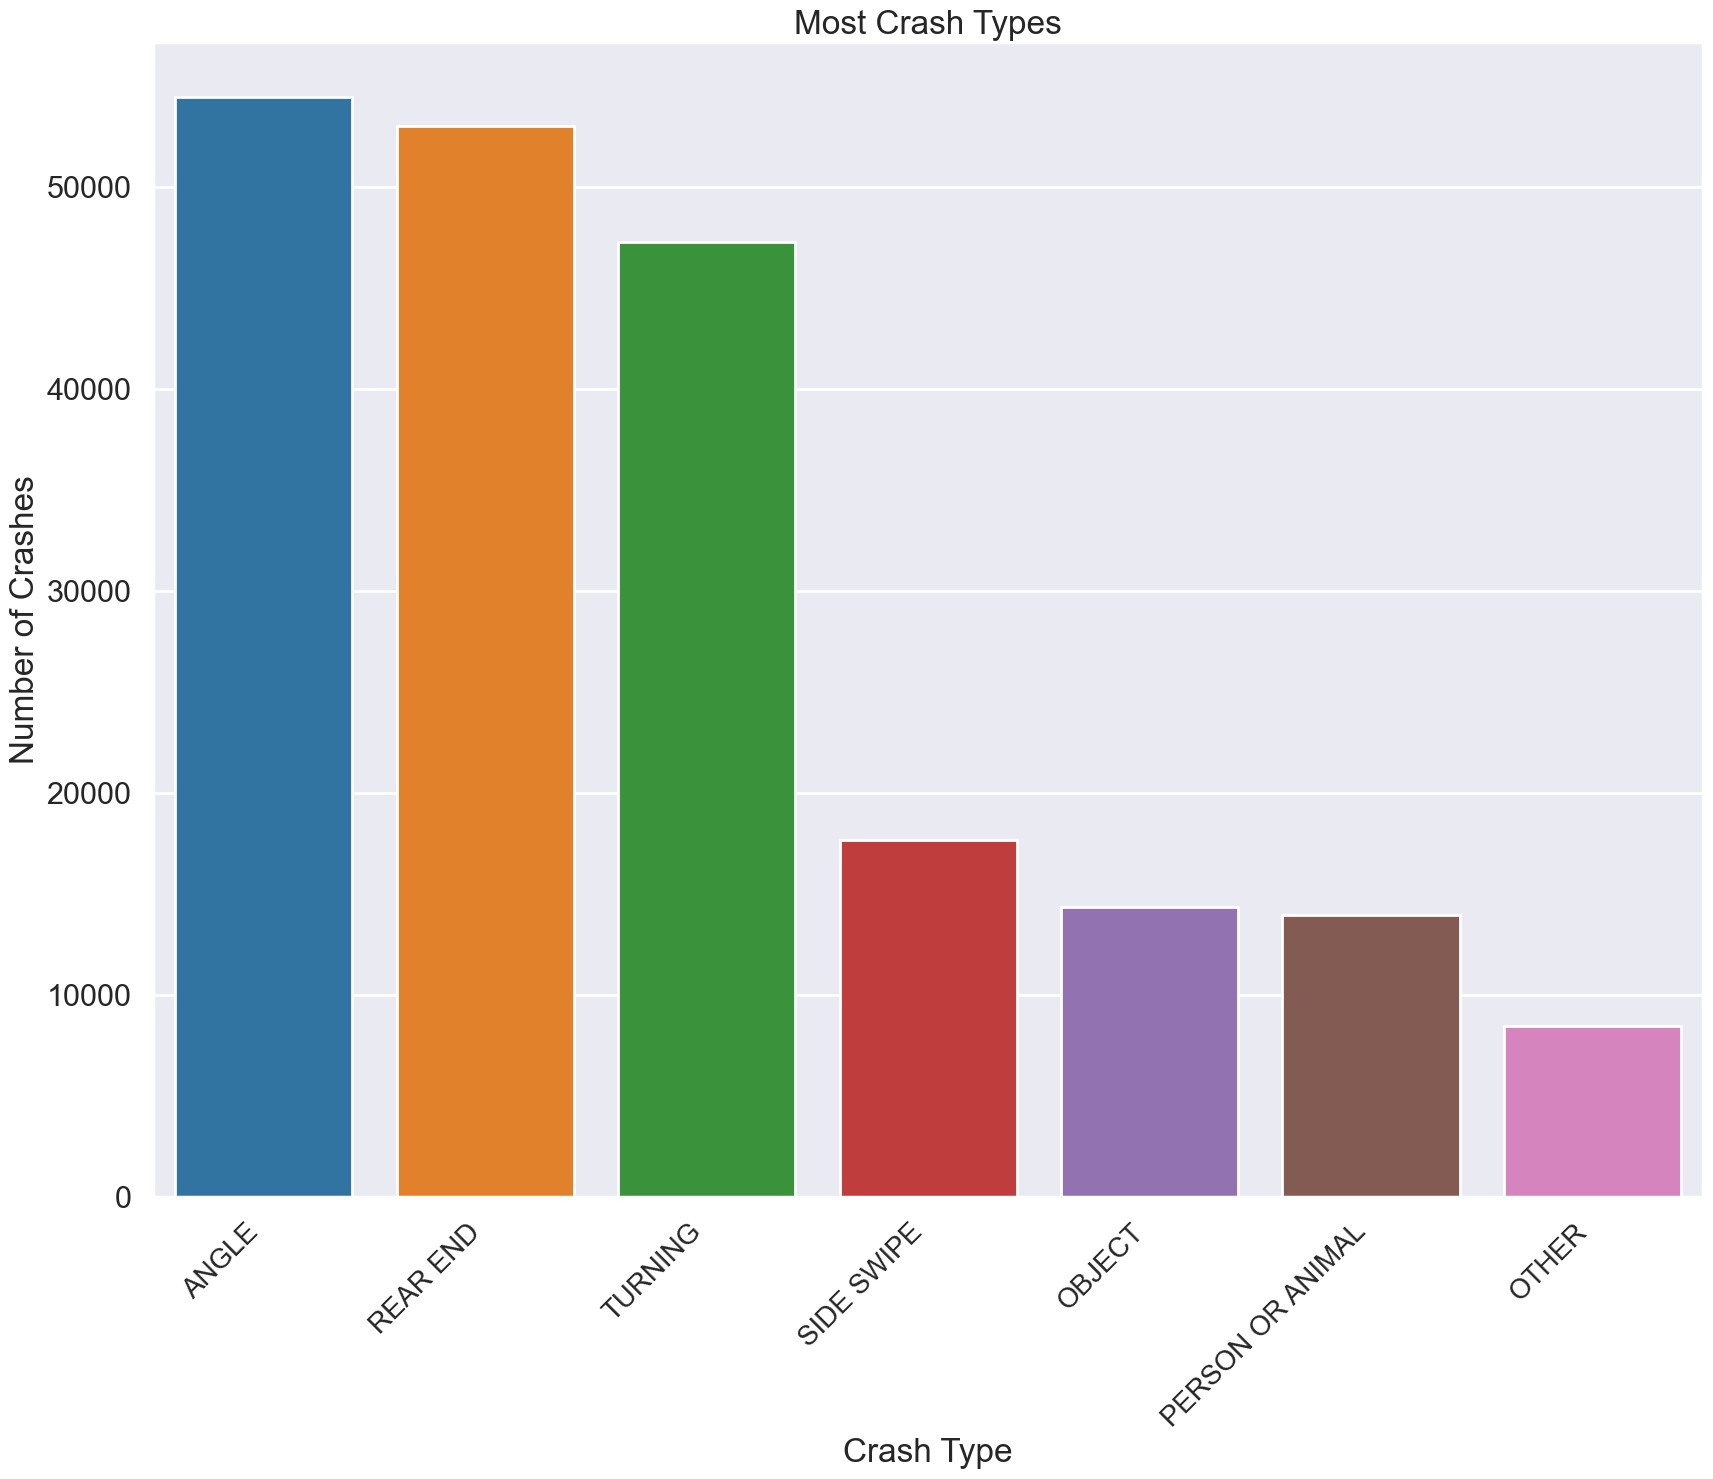

In [130]:
##CRASH TYPE

sns.set_context("poster")
sns.set_style("darkgrid")
plt.figure(figsize =(20,15))
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontsize='small'
)

ax = sns.countplot(x="FIRST_CRASH_TYPE", data=master_df, order=master_df['FIRST_CRASH_TYPE'].value_counts().index)
plt.xlabel('Crash Type')
plt.ylabel('Number of Crashes')
plt.title('Most Crash Types')
plt.show() 


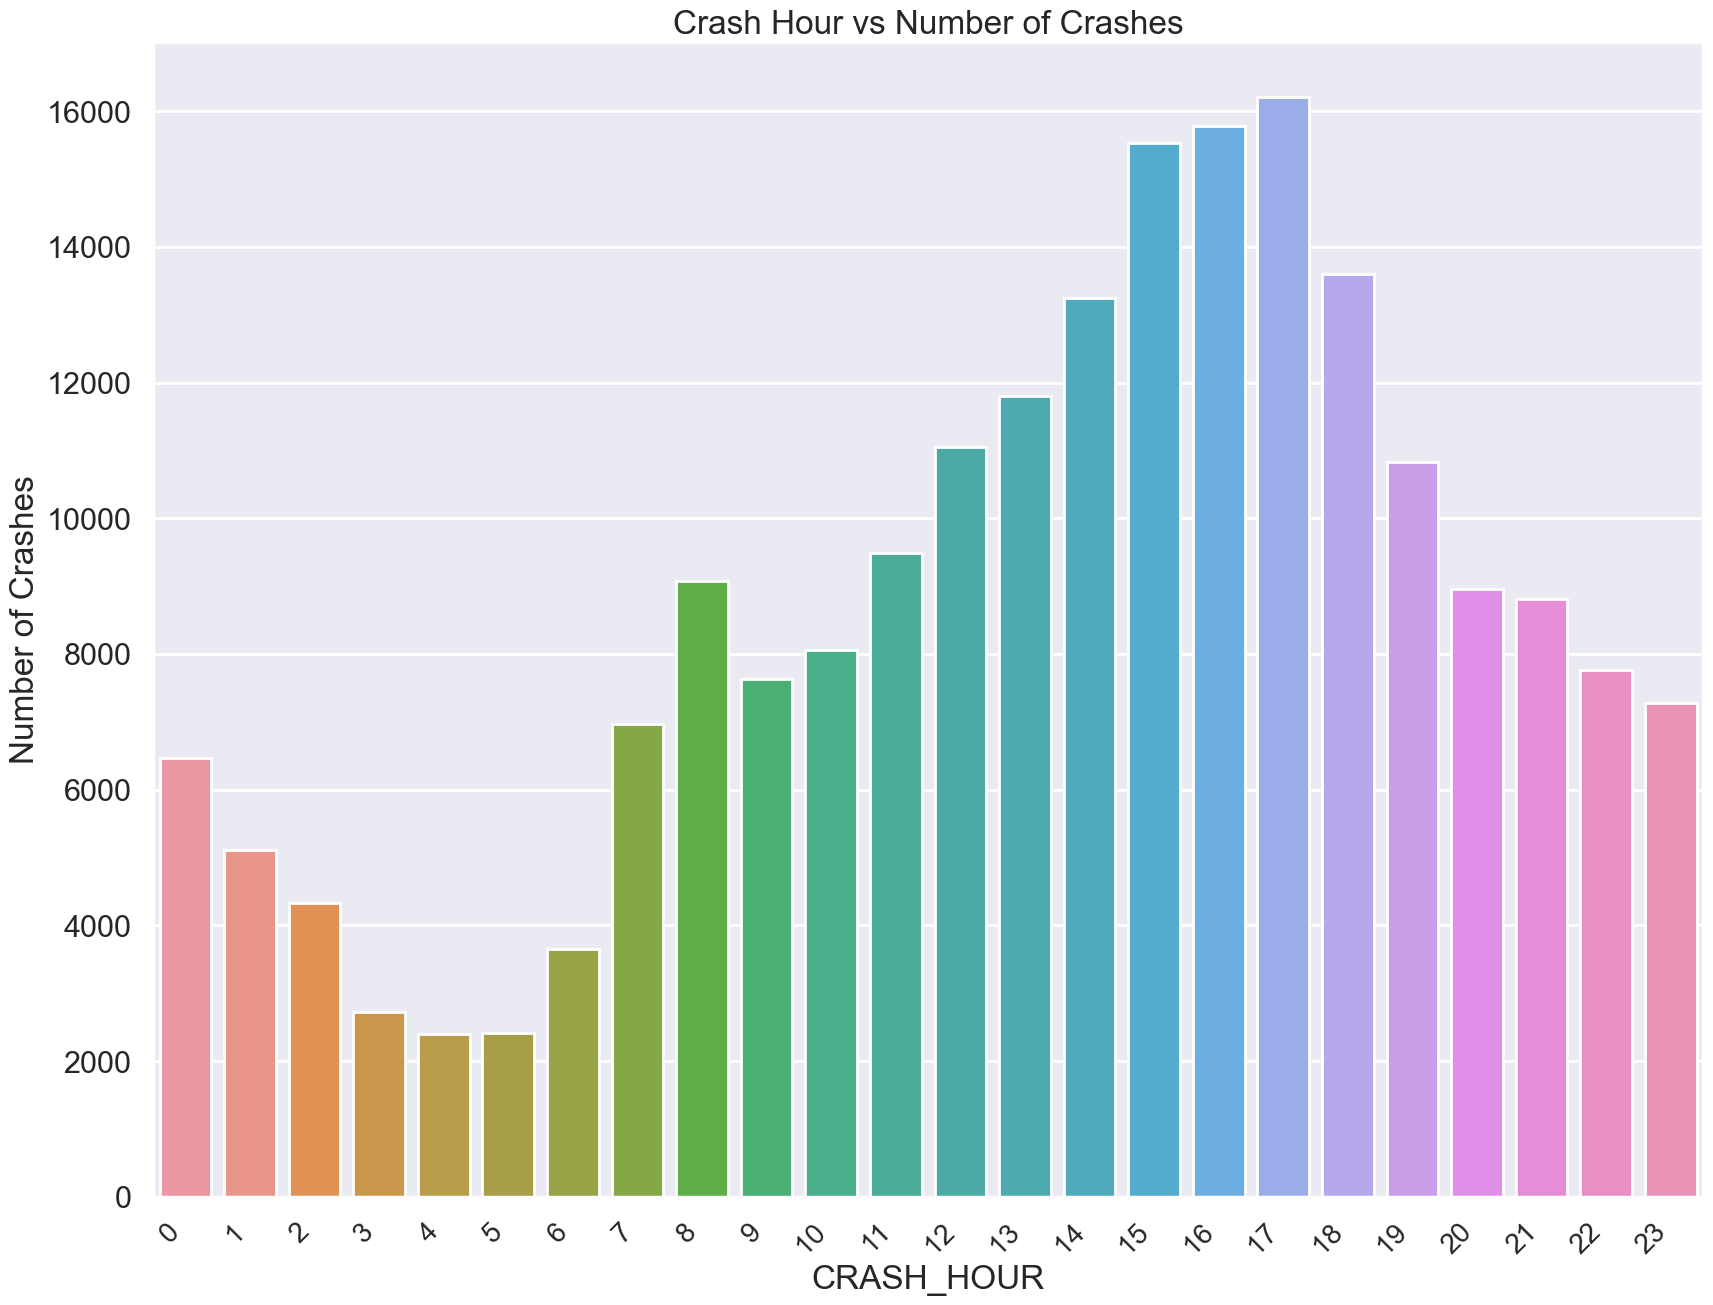

In [129]:
sns.set_context("poster")
sns.set_style("darkgrid")
plt.figure(figsize =(20,15))
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontsize='small'
)

ax = sns.countplot(x="CRASH_HOUR", data=master_df)
plt.xlabel('CRASH_HOUR')
plt.ylabel('Number of Crashes')
plt.title('Crash Hour vs Number of Crashes')
plt.show()